<a id='contents'></a>

# The shunPykeR's guide to single cell RNA-seq analysis

*Anastasia I Kousa and Lisa Sikkema*

In [5]:
from IPython.display import Image

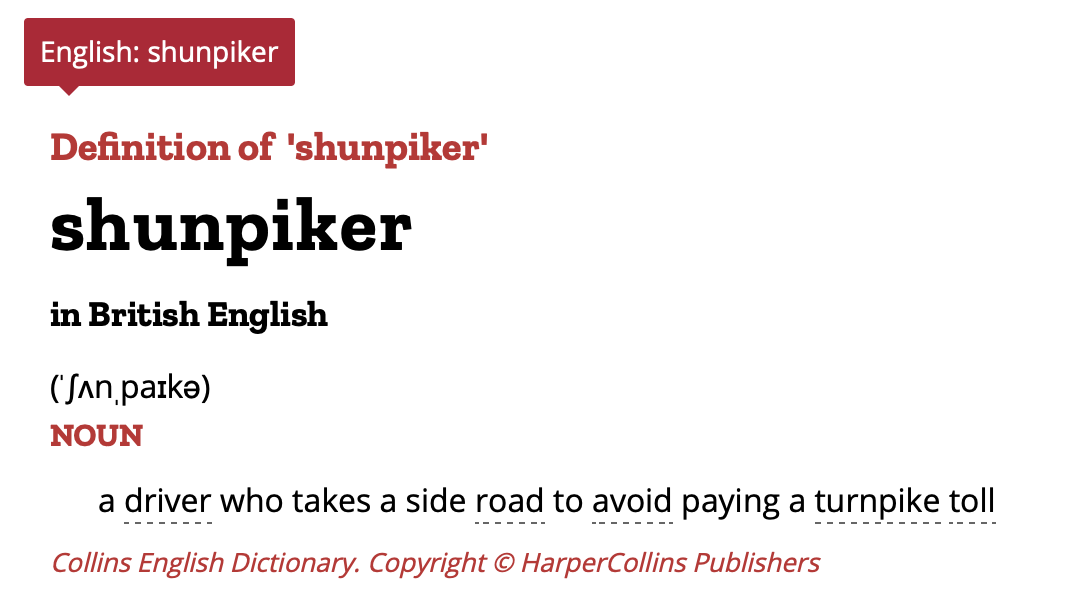

In [8]:
Image(filename="images/shunpiker_definition_logo.png", width="400")

*Similar to [the Hitchhiker's_Guide to the Galaxy](https://en.wikipedia.org/wiki/The_Hitchhiker%27s_Guide_to_the_Galaxy), this guide has probably ended up in your "hands" due to a great catastrophe: your single cell data need to be analyzed and you don't know how to do it. Well, **DON'T PANIC**, this guide is here to help you skip all the hurdles of coding and decision making and let you get the most out of your data.*

*This guide starts with a click on the `Run` button. Once that is done, just keep clicking...*




Image(filename="images/shunpiker_infographic.pdf", width="900")

###  This guide in a nutshell

This is a complete guide for the analysis of scRNA-seq datasets in a Jupyter notebook format. This guide has been simplified by hiding more complex code snipsets behind the scenes (within the `shunpiker_modules.py` file) allowing non computational scientists to perform a robust and thorough analysis of their scRNA-seq datasets with (relative) peace of mind. However, it can also be used by bioinformaticians that may want to adjust it and reuse it in their own way. 

Within this guide we have brought together a combination of already established scRNA-seq analysis tools, that we have put together in a logical order to simplify running your analysis. The main code is in python but it is interpolated snippets of R code to take advantage both worlds when using scRNA-seq developed algorithms.

Here is the list of tools that we implement across this guide:
- **scanpy**<sup>1</sup> provides the backbone of this pipeline and allows for visualization options (https://scanpy.readthedocs.io/en/stable/)
- **scrublet**<sup>2</sup> remove doublet cells (https://github.com/swolock/scrublet)
- **phenoGraph**<sup>3</sup> clusters cells based on their multi-dimensional enviroment (https://github.com/jacoblevine/PhenoGraph)


A general rule of thumb for the analysis of scRNA-seq dataset would be to discard "unwanted" cells on a per sample basis, while removing not expressed genes across all your samples together. **Step 1** in this notebook guides you through fully analyzing one sample from scratch to finish, and also store the results for integration with other samples if necessary. If you only have one sample, then **Step 1** is all you need. You can then skip to **Step 3** and **Step 4** to explore more visualization options for your data and perform differential expression analysis between your clusters of interest. If you have more than one sample, store good quality cells per sample using **Step 1** and then move to **Step 2** to integrate all your samples together. Then again move to **Step 3** and **Step 4** as described above. 


- **Step 1** Perform quality control and clean up each sample from scratch <a href='#part_1'>[here]</a>
- **Step 2** Intergrate together multiple "clean" samples <a href='#part_2'>[here]</a>
- **Step 3** Explore visualization alternatives <a href='#part_3'>[here]</a>
- **Step 4** Apply differential expression analysis <a href='#part_4'>[here]</a>

### What signs to look for?

This icon (🕹️) let's you know that manual input is needed

This icon (❗) asks you to pay attention

This icon (⏳) let's you know that the process is takes a long time to run

This icon (💡) gives you hints to assist with issues when running this pipeline

### Notebook setup

#### Import shunpiker pre-set packages and modules
 
For an introduction to python packages and modules, see https://realpython.com/python-modules-packages/#python-packages.    

In [3]:
# import shunpiker pre-set packages and modules
%run shunpiker_modules.py

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.3 scipy==1.6.2 pandas==1.3.0 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4
phenograph== 1.5.7


💡 **Hint:** Use the code below ONLY if you need to install extra packages

In [2]:
#import sys
#!{sys.executable} -m pip install watermark

#### Set notebook parameters

[`%matplotlib inline`](https://ipython.readthedocs.io/en/stable/interactive/tutorial.html#magics-explained) sets output of plotting commands to be displayed directly below the code cell that produced it.


<a id='part_1'></a>

## Sample "clean-up"

In [ ]:
# display plot directly below code cell
%matplotlib inline

### Read in scRNA-seq raw counts into a python object

❗ Choose between [cellranger](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/output/overview) and [SEQC](https://github.com/dpeerlab/seqc) data format for your input

Both data inputs will be converted into a scRNA-seq friendly python object called an AnnData object. The AnnData object is  is made up of several components. For a more detailed explanation, see https://anndata.readthedocs.io/en/latest/anndata.AnnData.html#anndata.AnnData. 

Once you execute either of the input commands below, you should be able to access:
- counts: `adata.X` + Run
- gene names: `adata.var` + Run
- cell index and other annotation: `adata.obs` + Run

#### Input cellranger data

The example below uses the Peripheral Blood Mononuclear Cells (PBMC) 10x public dataset (see [website](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)).

🕹️  Provide the path to your raw data and the name of your sample

In [3]:
# directory where the 10X MEX-format gene-barcode matrices are stored
path_to_10xdata = "data/10x/filtered_gene_bc_matrices/hg19/"

adata = sc.read_10x_mtx(path = path_to_10xdata,
                        var_names = "gene_symbols",
                        cache = True)

In [4]:
adata.obs.index.name = 'cell_barcodes'

In [5]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [6]:
adata.X = np.array(pd.DataFrame.sparse.from_spmatrix(adata.X).fillna(0)) # fill NAs with 0s

❗Using the line below you can check the number of cells (x, ) and genes ( ,y) that you have in your sample. 

In [7]:
# check the number of cells and genes
adata.shape

(2700, 32738)

This is a good sanity check after every filtering step to make sure the filters have been applied properly.

#### Input SEQC data

🕹️  Provide the path to your raw data and the name of your sample

In [ ]:
# type path to your SEQC data folder (replace example path with your path)
path_to_seqc_data = '/path/to/data/'

In [183]:
# type name of your file (replace example file name with your file name)
sample_name = 'sample_dense.csv'

In [184]:
# convert your selected sample/samples into one anndata object  
adata = import_seqc_data(path_to_seqc_data, sample_name)
adata.X = np.array(pd.DataFrame(adata.X).fillna(0)) # fill NAs with 0s

In [83]:
# randomize the order of cells for plotting
np.random.seed(42) 
index_list = np.arange(adata.shape[0])
np.random.shuffle(index_list)
adata = adata[index_list]

❗Using the line below you can check the number of cells (x, ) and genes ( ,y) that you have in your sample. 

This is a good sanity check after every filtering step to make sure the filters have been applied properly.

### Calculate quality control metrics for your sample before preprocessing

To start, we will calculate some standard quality control (QC) metrics using the `calc_QC_metrics()` function that is defined within the `shunpiker_modules.py` file. The QC metrics calculated include total counts, number of genes, and ribosomal and mitochondrial fraction on a per cell basis.

In [8]:
# caclutate QC metrics for your sample
calc_QC_metrics(adata)

❗To check if the QC metrics are now available for your sample, you can run the command below and inspect the column names.

In [9]:
# show top 5 rows from sample metadata (stored in adata.obs)
adata.obs.head()

n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
cell_barcodes                                                                
AAACATACAACCAC-1                781                 6.661855        2421.0   
AAACATTGAGCTAC-1               1352                 7.210080        4903.0   
AAACATTGATCAGC-1               1131                 7.031741        3149.0   
AAACCGTGCTTCCG-1                960                 6.867974        2639.0   
AAACCGTGTATGCG-1                522                 6.259581         981.0   

                  log1p_total_counts  pct_counts_in_top_50_genes  \
cell_barcodes                                                      
AAACATACAACCAC-1            7.792349                   47.748864   
AAACATTGAGCTAC-1            8.497807                   45.502753   
AAACATTGATCAGC-1            8.055158                   41.314703   
AAACCGTGCTTCCG-1            7.878534                   39.029936   
AAACCGTGTATGCG-1            6.889591                   44.852192   

                  pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
cell_barcodes                                                                
AAACATACAACCAC-1                    63.279637                    74.969021   
AAACATTGAGCTAC-1                    61.023863                    71.813176   
AAACATTGATCAGC-1                    53.794856                    65.449349   
AAACCGTGCTTCCG-1                    52.898825                    66.691929   
AAACCGTGTATGCG-1                    55.657492                    67.176351   

                  pct_counts_in_top_500_genes  original_total_counts  \
cell_barcodes                                                          
AAACATACAACCAC-1                    88.393226                 2421.0   
AAACATTGAGCTAC-1                    82.622884                 4903.0   
AAACATTGATCAGC-1                    79.961893                 3149.0   
AAACCGTGCTTCCG-1                    82.569155                 2639.0   
AAACCGTGTATGCG-1                    97.757390                  981.0   

                  log10_original_total_counts  mito_frac  RBP_frac  
cell_barcodes                                                       
AAACATACAACCAC-1                     3.383995   0.030153  0.444444  
AAACATTGAGCTAC-1                     3.690462   0.037936  0.433204  
AAACATTGATCAGC-1                     3.498173   0.008892  0.325818  
AAACCGTGCTTCCG-1                     3.421439   0.017431  0.250853  
AAACCGTGTATGCG-1                     2.991669   0.012232  0.155963

### Data "clean-up": identification of doublet cells

We will use the scanpy implementation ([`scanpy.external.pp.scrublet`](https://scanpy.readthedocs.io/en/latest/generated/scanpy.external.pp.scrublet.html#scanpy-external-pp-scrublet)) of the [scrublet package](https://github.com/swolock/scrublet) to identify doublet cells. This command will use the default parameters of `scanpy.external.pp.scrublet`, however, if you are feeling brave or disagree with the predicted doublets you can use this [example notebook](https://github.com/swolock/scrublet/blob/master/examples/scrublet_basics.ipynb) to alter any of these parameters.

In [10]:
# run scanpy implementation of the scrublet package to identify doublet cells
sc.external.pp.scrublet(adata)

/home/kousaa/miniconda3/envs/scanpy_1.8.1/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.27
Detected doublet rate = 1.6%
Estimated detectable doublet fraction = 44.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.5%


### Data "clean-up": removal of not expressed genes

Genes with zero counts across all cells will not provide any biological insight, but rather delay some of the downstream processing steps, thus we choose to remove genes that are not expressed in any cells. You can make this step more stringend by asking genes to be expressed in at least N number of cells.

In [11]:
# remove genes that are not expressed in any cells (remove columns with all 0s)
sc.pp.filter_genes(adata, min_cells=1)

### Data "clean-up": removal of rRNA

Ribosomal protein (RBP) RNA often constitutes between 20-50% of your counts. Variation in their expression can therefore highly affect the outcome of your visualization algorithms and differential gene expression analyses. Our experience is that expression levels of RBP RNA often cannot be reproduced or validated, and are moreover difficult to interpret. One can therefore decide to remove these genes from the data altogether.

In [12]:
adata = remove_RBs(adata)

### Data "clean-up": data normalization

RNA counts generally vary linearly with library size: RNA molecules have a steady concentration rather than a steady absolute number (Additional variation suggests biological variation in gene expression among your cells). Therefore, it is usually appropriate to normalize each cell to the same total library size, thereby converting RNA counts to a relative rather than absolute count. Below a random gene is plotted against library size to show that expression, at least if not variable between cell types in your sample, changes according to library size. We take a gene with a minimum gene expression of 1, because trends in genes with low mean expression are occluded by noise. Run the cell below a few times to inspect the general trend between gene expression and library size. Note that scRNA-seq data is highly noisy, and the correlation will therefore be noisy as well in genes with lower expression.

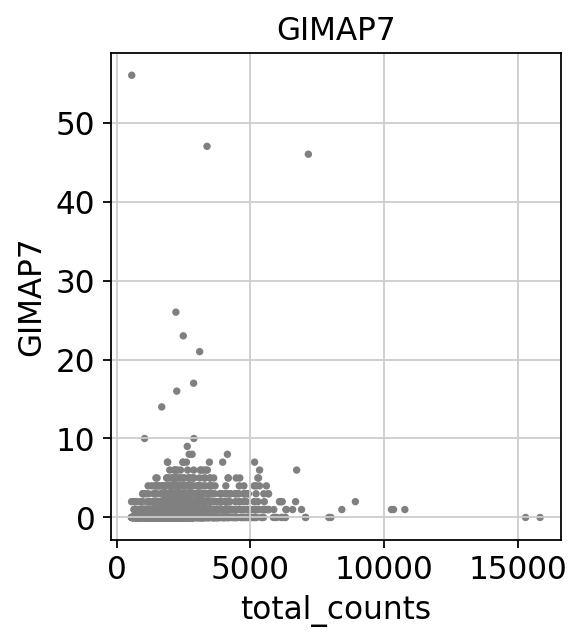

In [13]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
observe_library_size_effect(adata)

An alternative method to normalize data is using SCRAN that applies a similar principle to common normalization methods in bulk RNA data.

Here we will normalize to a total library size of 10,000. Scanpy will update our count matrix (adata.X) automatically with the normalized counts.

In [14]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=10**4)

Trying to set attribute `.obs` of view, copying.


### Data "clean-up": log-transformation

Log transformation makes changes in expression relative rather than absolute (e.g. it looks at doubling (when using log2) of expression rather than increase of n counts in expression). It makes the differences between highly and lowly expressed genes smaller, and limits the effects of highly expressed genes on your data analysis. It is often considered a default part of preprocessing, but can occasionally be better left out. The desired effect of a log-transformation is that it brings out biological differences between your cell populations better. <br>
Scanpy's log transformation function takes the natural logarithm of each (count + 1), and updates your count matrix (adata.X): 

In [15]:
sc.pp.log1p(adata)

### Let's have a look at our data

UMAP embedding gives us a two-dimensional representation of our data, based on the similarities/differences among the cells in a higher-dimensional space. Each type of mapping has its own strenghts and weaknesses, thus it can be useful to take a look at different mappings. Using a selection of principal components before UMAP will not only shorten computation time, but also reduces noise.

In [16]:
rng = np.random.RandomState(42)
adata = sc.tl.pca(adata, n_comps=200, copy = True, svd_solver='arpack', random_state=rng)

We can visualize the percentage of variance explained by each PC. Based on this figure, we will select a number of principal components to use in the rest of our analysis. 

<function matplotlib.pyplot.show(close=None, block=None)>

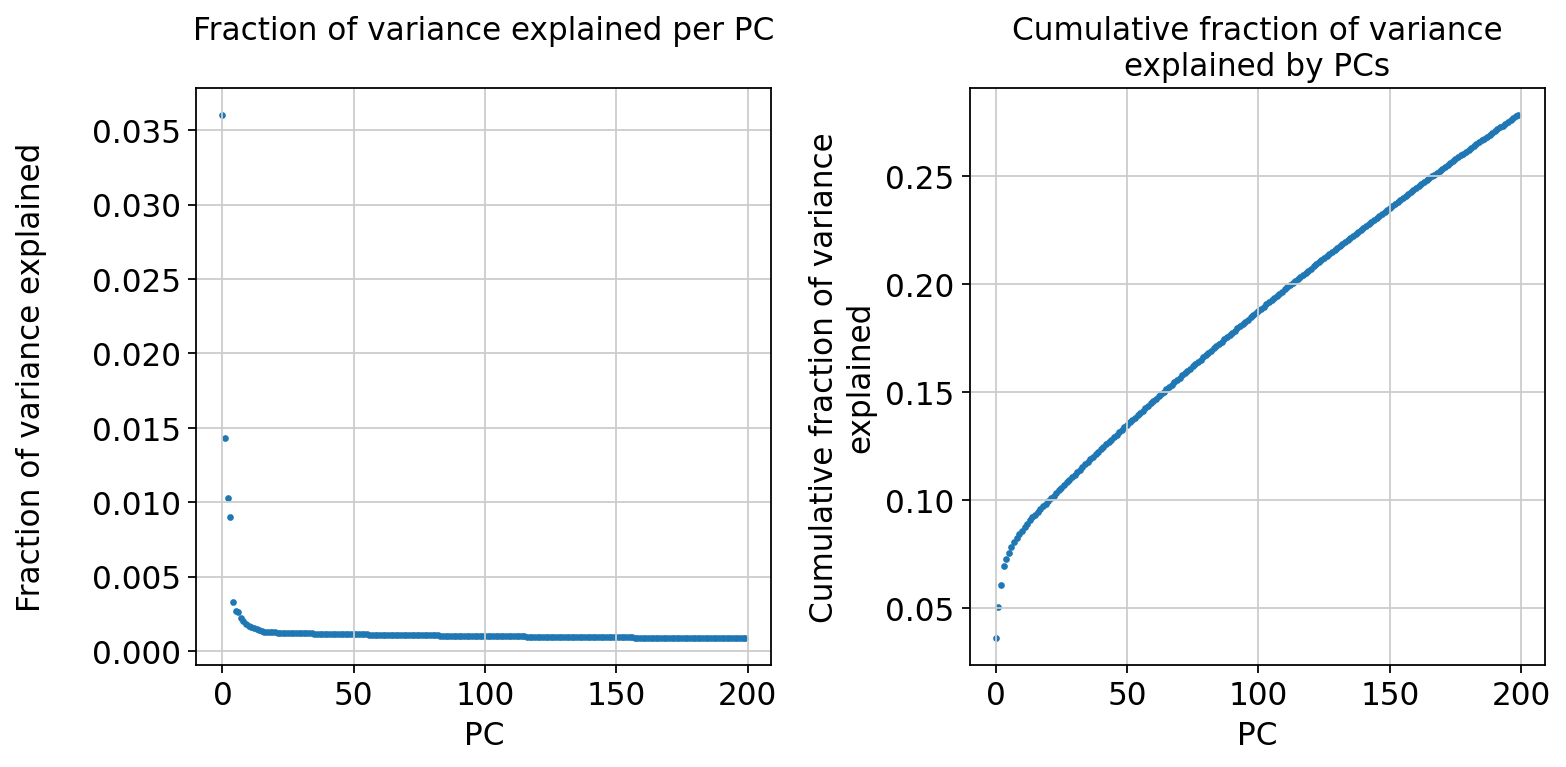

In [17]:
observe_variance(adata)

❗ We want to include all the principal components before the 'knee point' (the point where the fitted curve would change slope the most), because these likely represent important sources of variance in our data. To try to avoid eliminating any relevant but small sources of variance, we will choose a number of PCs slightly to the right of the knee point. 

🕹️  Replace the number below with your selection and run PCA again.

In [28]:
rng = np.random.RandomState(42)
sc.tl.pca(adata, n_comps=25, svd_solver='arpack', random_state=rng)

We will now run UMAP. When dealing with a very large dataset, it might be useful to use a perplexity higher than the default (`n_neighbors=15`). The command below will automatically use our PCA as a basis for calculating the embedding.

In [29]:
sc.pp.neighbors(adata, n_neighbors=15)

In [30]:
sc.tl.umap(adata)

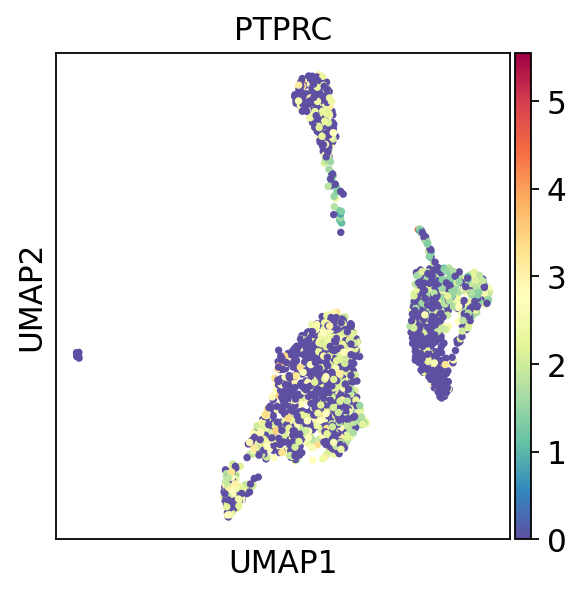

In [31]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
# plot major canonical markers as a sanity check
sc.pl.umap(
    adata, 
    color=['PTPRC'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

🕹️ Inspect canonical markers of your choice

❗ **Does your data look well distinguished?** If yes, move ahead. If no, maybe try to increase the number of principal components you used, and rerun the last bits of code.

### Run unsupervised clustering analysis using PhenoGraph

Next, we will filter out cells that we think are either dying cells or empty droplets. Both are characterized by low library size, dying cells additionally have relatively high percentages of mitochondrial RNA. Rather than using cutoffs, we remove cells by cluster. This prevents us from taking out cells that belong to a biologically relevant cluster, despite having e.g. low library size or high mitochrondrial RNA. It furthermore ensures that we take out all cells with a phenotype similar to what we think are cells that should be taken out, even if they happen not to exceed a possible cutoff we would have otherwise chosen. We can furthermore remove clusters that we are not interested in, such as doublets and contaminants.

For clustering, we use [PhenoGraph](https://www.sciencedirect.com/science/article/pii/S0092867415006376). This is a highly robust graph-based clustering algorithm that was designed for single cell data. Your choice of k (number of nearest neighbors to use for graph construction) can affect the number of clusters and their size.

❗ How to select a number for neighbour cells (k) for fairly robust clustering.

Calculate clustering characteristics for a range of ks (5 to 155), by a step of 5.

Inspect the following clustering metrics:
- Minimum number of k for a connected graph.
- Changes in Q-modularity score (see PhenoGraph paper) for different ks. The Q-modularity usually drops quickly in the beginning (due to swiftly increasing connectedness when increasing a low k), and only slightly decreases after a certain point. However, in the case of homogeneous data with little structure, you might see a constant rapid decay in Q score. The plot below is not needed for a good choice of k, but is informative about the modularity of your data.
- Similarity/difference in cluster assignments between the different ks. We will use the Rand index to this end. The Rand index algorithm compares to clusterings by testing for every pair of cells, whether or not they were both clustered together or separately in both clusterings. E.g. if two cells were not in the same cluster in clustering 1, but were clustered together in clustering 2, this will decrease the Rand score. Alternatively, if they were in separate clusters in both cases, or in the same cluster in both cases, this will increase the score. The Rand index ranges from 0 to 1, with 1 indicating identical cluster assignments. We will calculate the Rand indices for all pairs of k and visualize the Rand indices using a heatmap, with our chosen range of k in the rows and columns, and the color indicating similarity in cluster assignments (red=high similarity, blue=low similarity). We can use the heatmap to find a region of ks where the clustering is fairly similar between runs (e.g. an index around 0.8 or higher). Within that 'robust region', we should choose a low k to retain as much resolution as possible.

⏳ This step might take a while so be patient

In [1]:
# calculate clustering characteristics for a range of ks (5 to 155), by a step of 5.
ks = np.arange(5,155,5) 
cluster_chars = [calc_clustering_characteristics(k, adata.obsm['X_pca']) for k in ks];

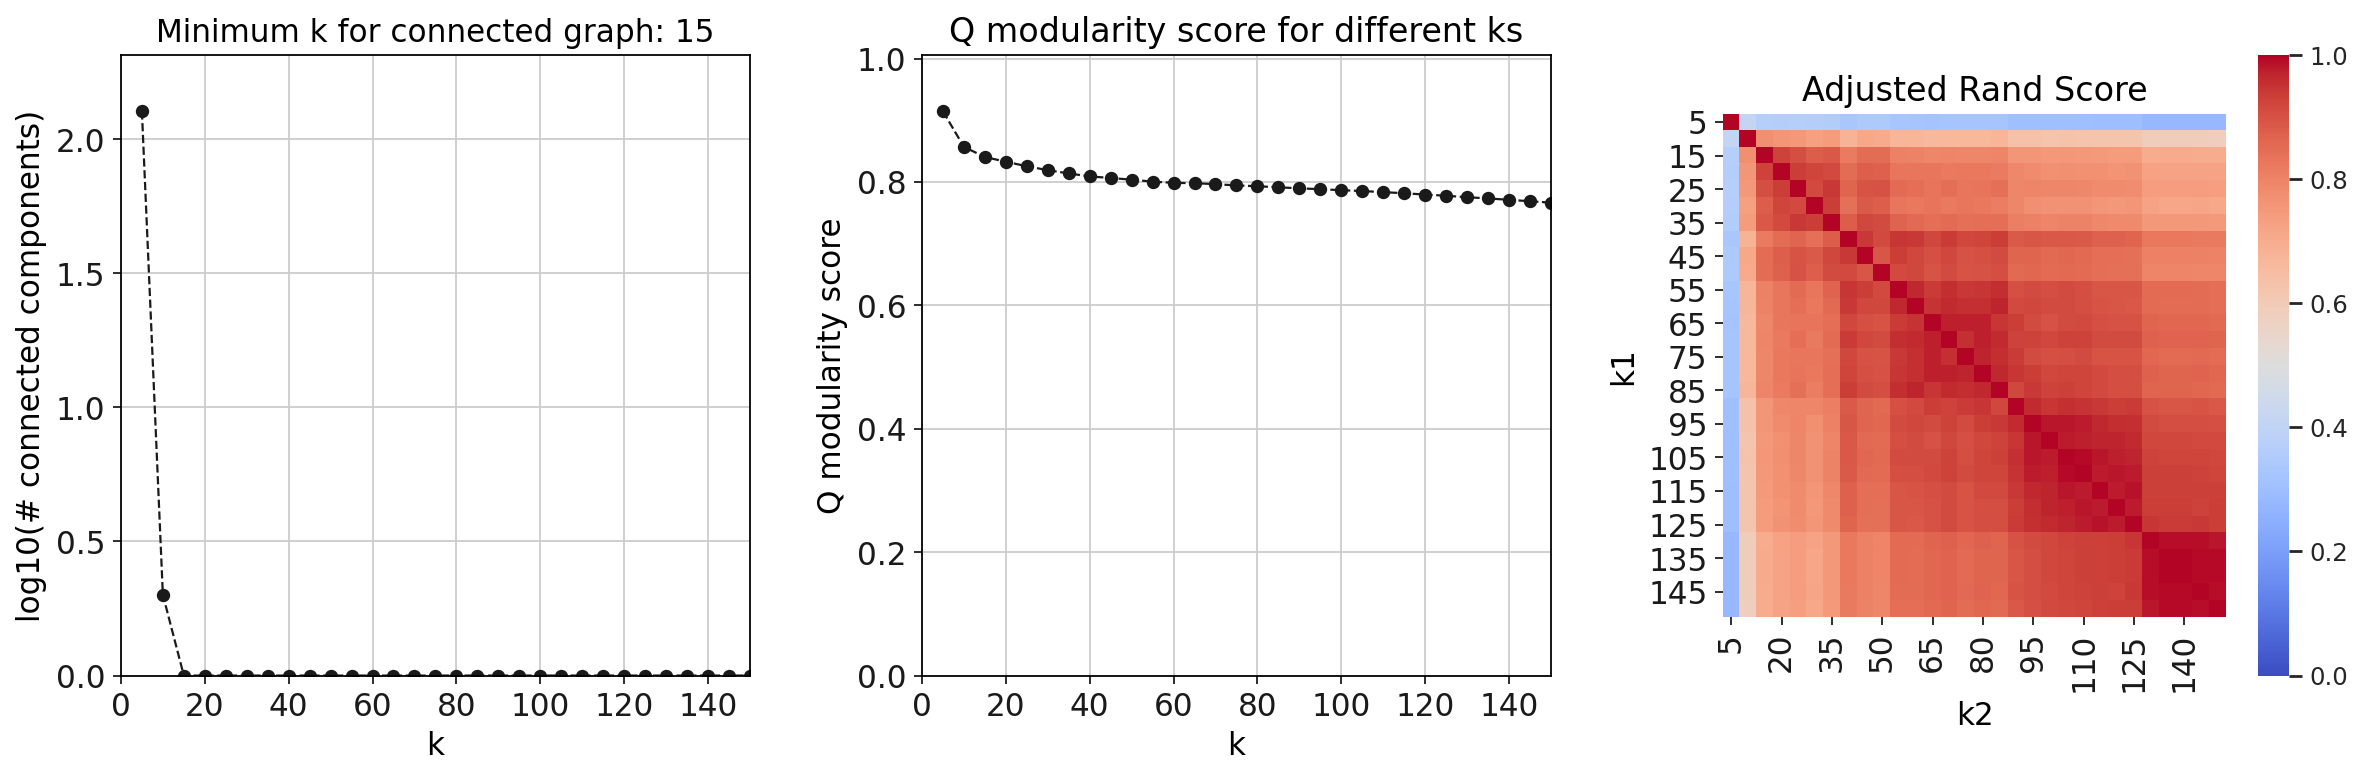

In [33]:
# plot clustering metrics
Rand_index_df = inspect_clustering_chars(ks, cluster_chars)

In [34]:
# print table with rand scores for the different ks
Rand_index_df.iloc[1:5,1:10]

k2        10        15        20        25        30        35        40  \
k1                                                                         
10  1.000000  0.775981  0.759734  0.752348  0.732334  0.743960  0.681936   
15  0.775981  1.000000  0.929018  0.909743  0.880351  0.890189  0.820117   
20  0.759734  0.929018  1.000000  0.935479  0.922385  0.915629  0.847960   
25  0.752348  0.909743  0.935479  1.000000  0.917017  0.943733  0.863428   

k2        45        50  
k1                      
10  0.711247  0.706184  
15  0.850607  0.848026  
20  0.878386  0.873504  
25  0.895922  0.901561

🕹️ Using the heatmap and table above choose a value for k. 

As rule of thumb, choose a connected graph k with an adjusted Rand score >=0.8 for 4 consecutive steps. 

In [35]:
# run unsupervised clustering analysis with PhenoGraph
k=15 # add your selected k value here
communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata.obsm['X_pca']),k=k)
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.14443087577819824 seconds
Jaccard graph constructed in 6.003967046737671 seconds
Wrote graph to binary file in 0.023291349411010742 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.83933
Louvain completed 21 runs in 2.0600504875183105 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 13.41246747970581 seconds


We can visualize the clustering to see which clusters match with the cells that we would like to filter out. Inspect the list of QC metrics and canonical markers to make your choice.

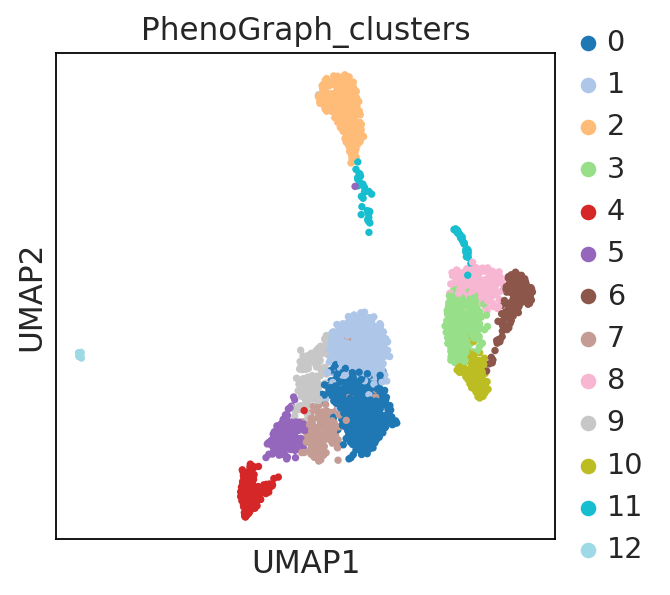

In [36]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.5,
    sort_order = False
)

### Filtering out cells: by cluster

Now inspect tha QC metrics for each of the clusters and choose to remove any clusters that may have a combination of bad quality metrics.

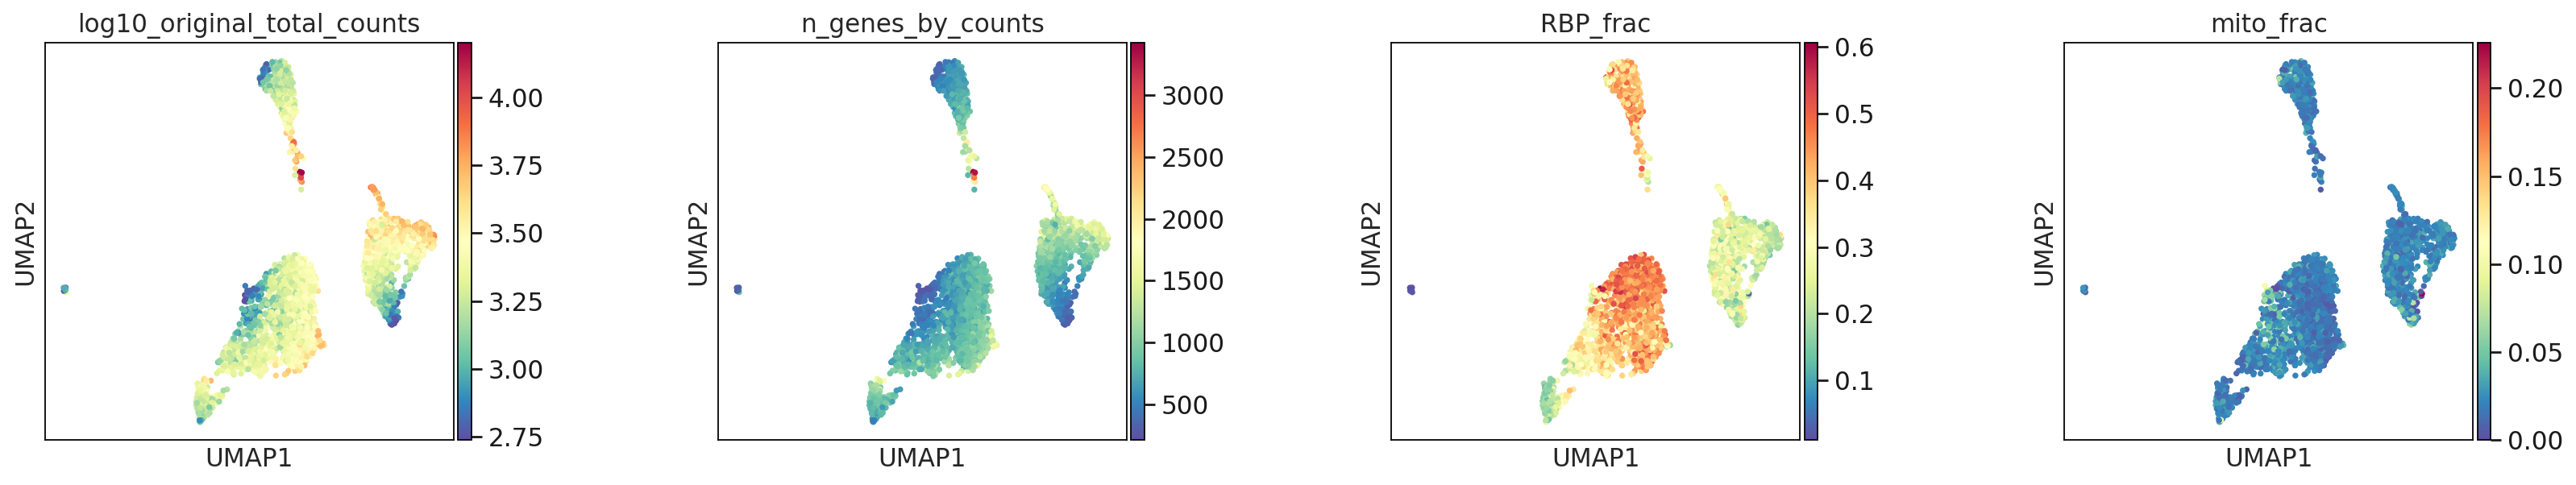

In [37]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
sc.pl.umap(
    adata, 
    color=['log10_original_total_counts', 'n_genes_by_counts','RBP_frac', 'mito_frac'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.5,
    sort_order = False
)

In [38]:
adata.shape

(2700, 16466)

Choose which clusters you want to remove, and add them to the list clusters_to_remove below.

In [39]:
clusters_to_remove = [9,10]
cluster_filter = [x not in clusters_to_remove for x in adata.obs['PhenoGraph_clusters']]
print('Total number of cells pre-filtering: ' + str(adata.shape[0]))
print('Number of cells to keep after filtering: ' + str(sum(cluster_filter)))
adata_filtered = adata[cluster_filter]

Total number of cells pre-filtering: 2700
Number of cells to keep after filtering: 2465


Check if the right clusters were removed.

Trying to set attribute `.uns` of view, copying.


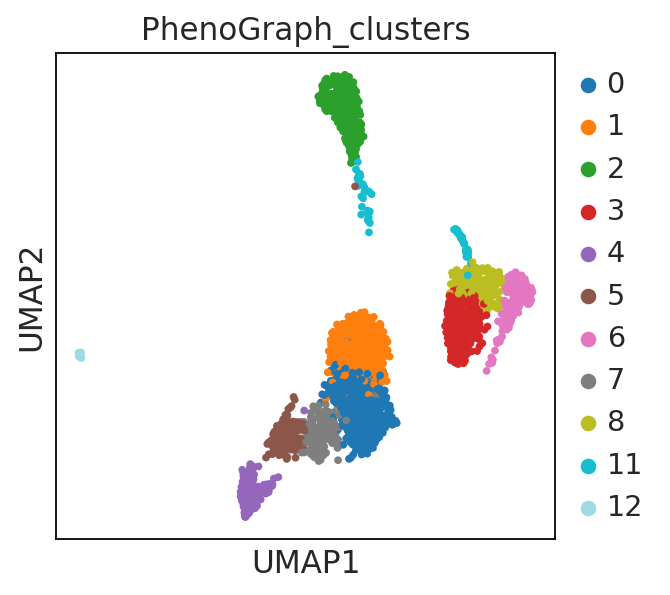

In [40]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
sc.pl.umap(
    adata_filtered, 
    color=['PhenoGraph_clusters'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.5,
    sort_order = False
)

If the right clusters and doublets were removed continue in the next line to store the result in your adata object.

In [41]:
adata = adata_filtered

In [42]:
adata.shape

(2465, 16466)

### Filtering out cells: doublets and contaminants

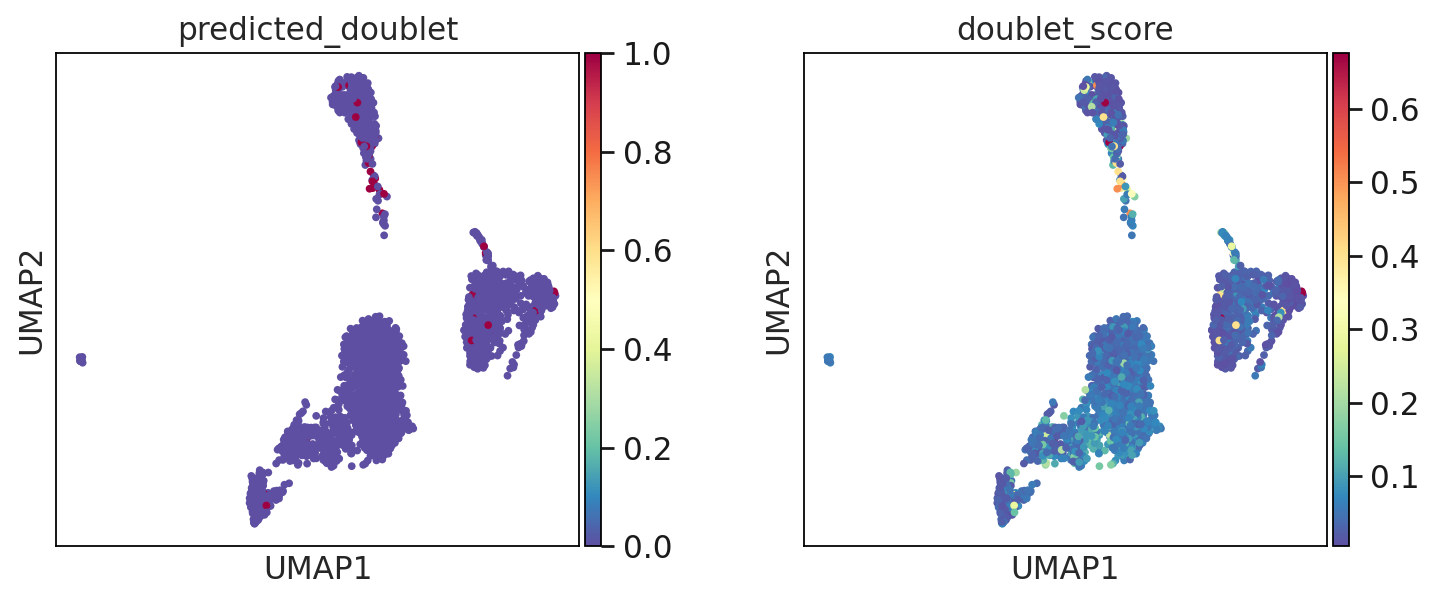

In [43]:
sc.pl.umap(
    adata_filtered, 
    color=['predicted_doublet', 'doublet_score'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

This would be also a good spot to remove the doublets you have identified above or any other cell population that does not match your experimental strategy

In [44]:
adata = adata[adata.obs['predicted_doublet'] == False]

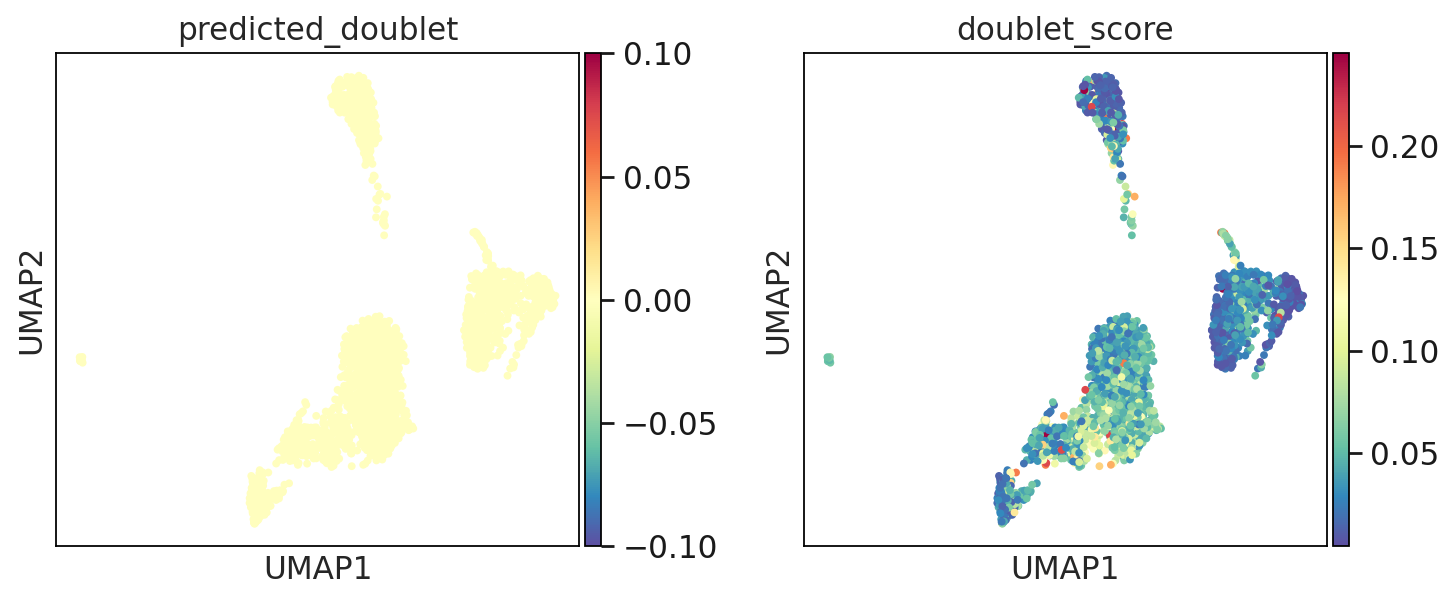

In [45]:
sc.pl.umap(
    adata, 
    color=['predicted_doublet', 'doublet_score'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

Let's now inspect if the right number of doublet cells has been removed from the dataset.

In [46]:
adata.shape

(2426, 16466)

### Reanalyze data after removal of cells

Once we have removed all unwanted cells, we need to reanalyze our data in a similar way to steps 4 and 5. 

In [47]:
rng = np.random.RandomState(42)
adata = sc.tl.pca(adata, n_comps=200, copy = True, svd_solver='arpack', random_state=rng)

<function matplotlib.pyplot.show(close=None, block=None)>

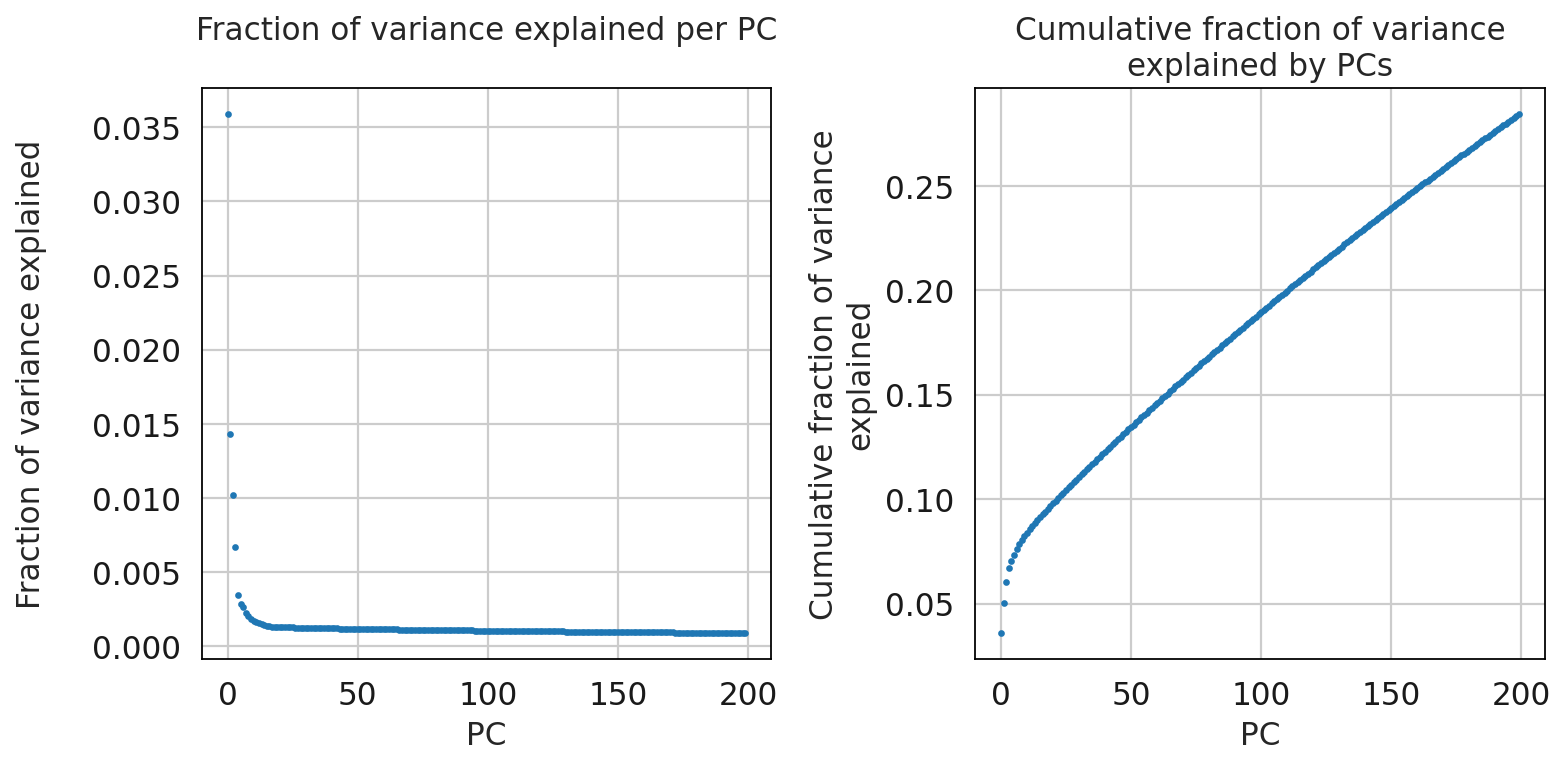

In [48]:
observe_variance(adata)

🕹️ Remember to choose a different number of principal components based on the re-analysis

In [49]:
rng = np.random.RandomState(42)
sc.tl.pca(adata, n_comps=25, svd_solver='arpack', random_state=rng)

In [50]:
sc.pp.neighbors(adata, n_neighbors=15)

In [51]:
sc.tl.umap(adata)

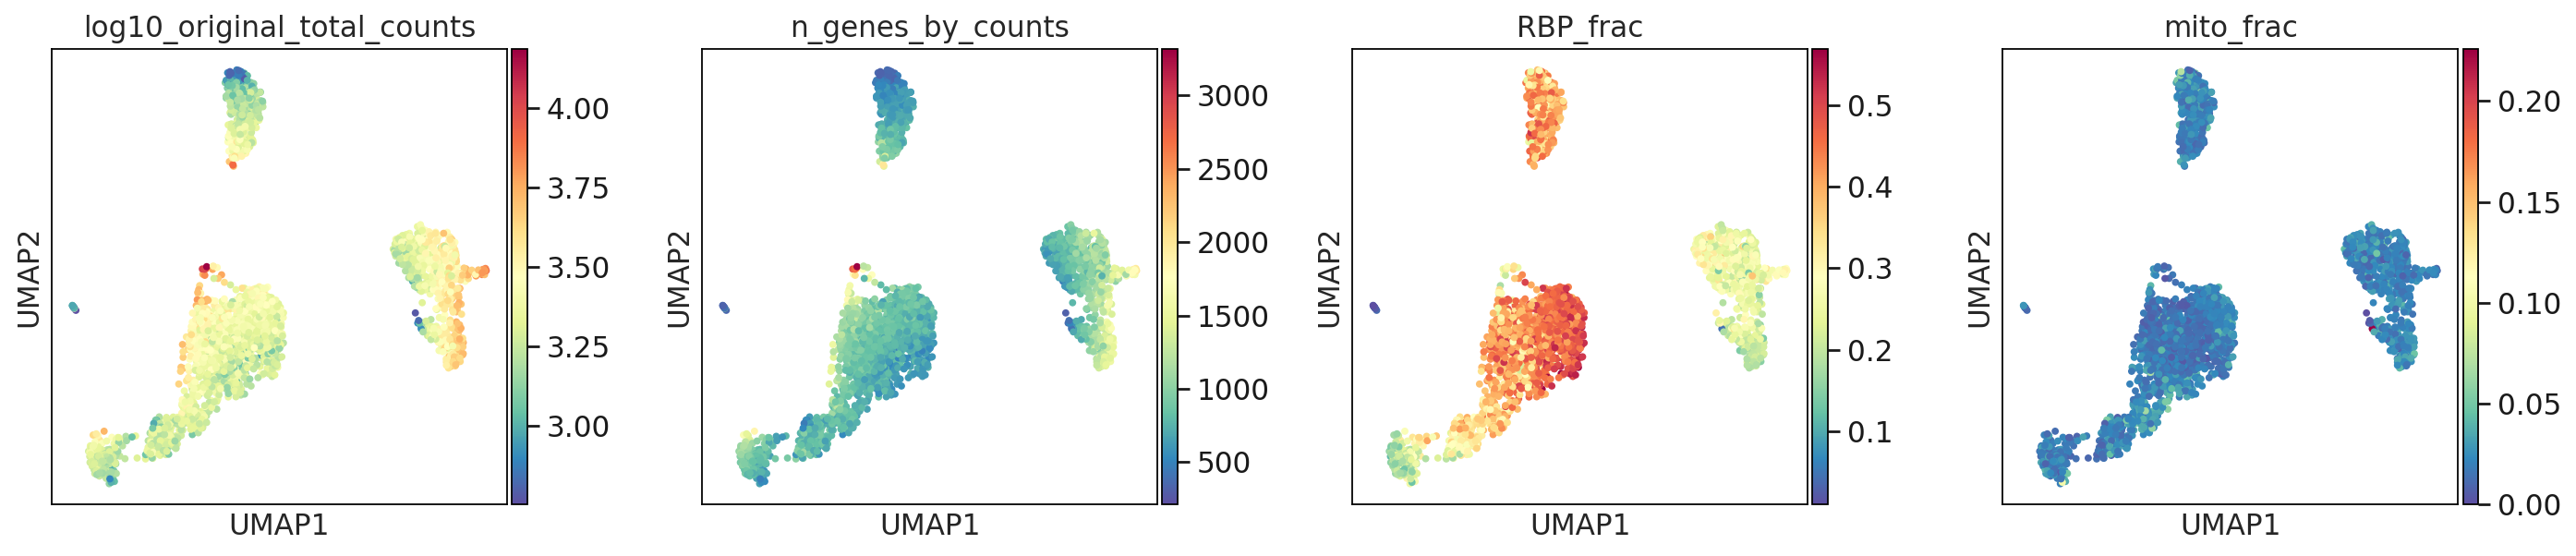

In [53]:
sc.pl.umap(
    adata, 
    color=['log10_original_total_counts', 'n_genes_by_counts','RBP_frac', 'mito_frac'], 
    palette='tab20', 
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

⏳ Once again find a robust k-value.

In [2]:
ks = np.arange(5,155,5)
cluster_chars = [calc_clustering_characteristics(k, adata.obsm['X_pca']) for k in ks]

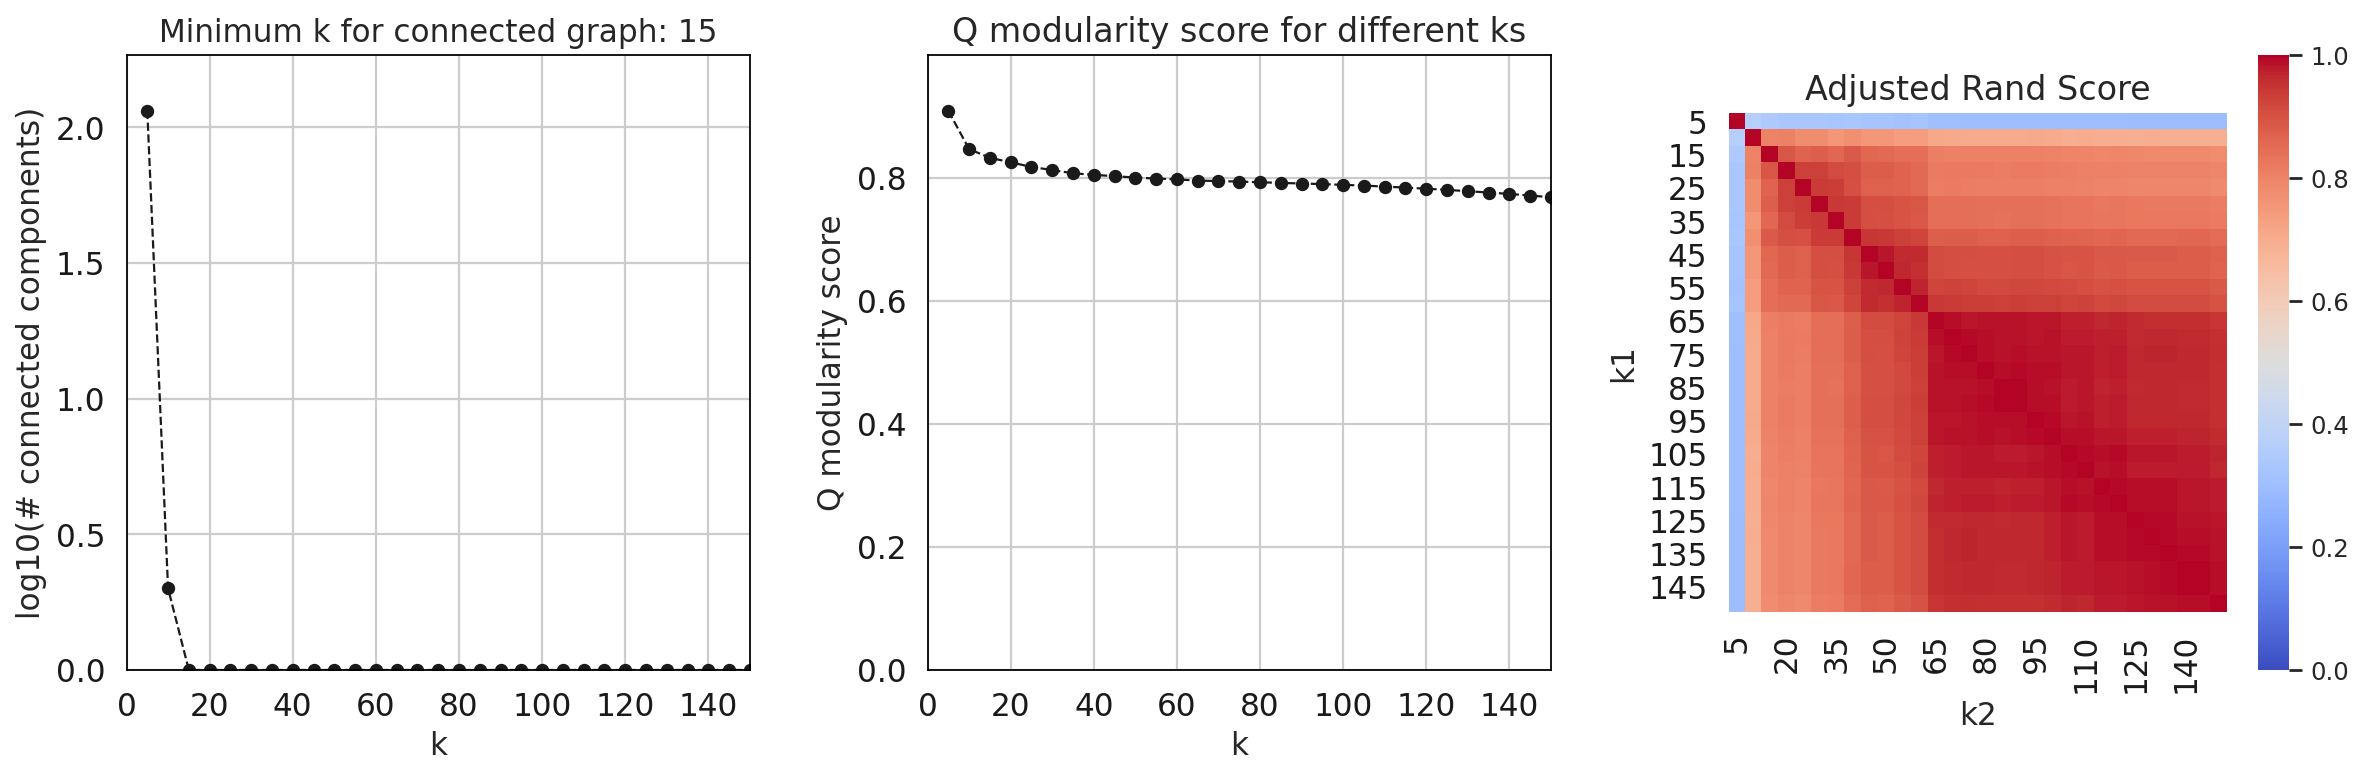

In [55]:
Rand_index_df = inspect_clustering_chars(ks, cluster_chars)

In [56]:
Rand_index_df.iloc[1:5,1:10]

k2        10        15        20        25        30        35        40  \
k1                                                                         
10  1.000000  0.803679  0.804824  0.777978  0.780350  0.756263  0.774624   
15  0.803679  1.000000  0.890759  0.870190  0.876143  0.860967  0.882968   
20  0.804824  0.890759  1.000000  0.932676  0.929838  0.912469  0.907391   
25  0.777978  0.870190  0.932676  1.000000  0.938133  0.935828  0.902528   

k2        45        50  
k1                      
10  0.754686  0.757237  
15  0.862098  0.858589  
20  0.880984  0.879943  
25  0.874587  0.872816

In [57]:
# add your selected k value here to proceed
k=15
communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata.obsm['X_pca']),k=k)
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.1862776279449463 seconds
Jaccard graph constructed in 11.682889461517334 seconds
Wrote graph to binary file in 0.03203129768371582 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.832057
After 2 runs, maximum modularity is Q = 0.833246
Louvain completed 22 runs in 3.89793062210083 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 26.0896098613739 seconds


We can visualize the clustering to see which clusters match with the cells that we would like to filter out. Inspect the list of QC metrics and canonical markers to make your choice.

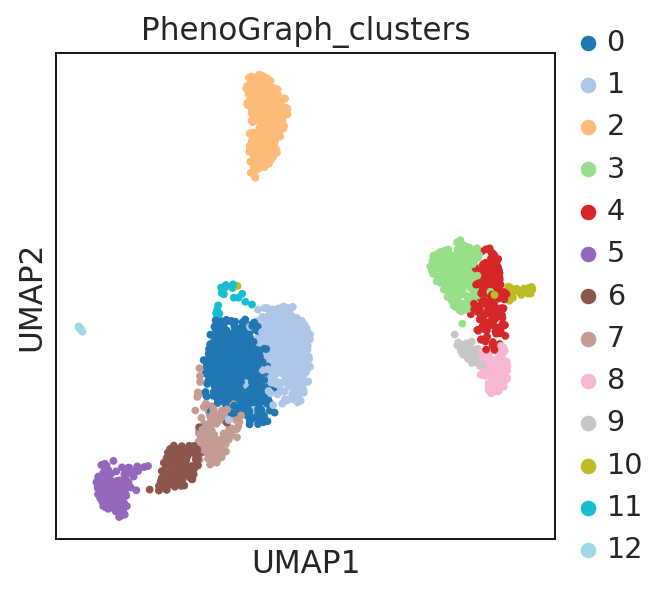

In [58]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

You are done! Just save you file and save the index of you cells. Make sure your path ends with the desired filename including the .h5ad file extension. You can now come back to this dataset at anytime.

In [59]:
adata.shape

(2426, 16466)

In [60]:
path_to_h5ad = 'files/anndata_objects/3K_PBMCs.h5ad'

In [61]:
adata.write(path_to_h5ad)

In [15]:
adata = sc.read_h5ad(path_to_h5ad)

Save index of your good quality cells if you have multiple samples to integrate.

In [62]:
QCpassed_cells = adata.obs.index
QCpassed_cellsDF = pd.DataFrame(QCpassed_cells)
QCpassed_cellsDF.to_pickle('files/annotated_cells/3K_PBMCs_QCpassed.pkl')

**Well done!** You have reached the end of Step 1.

Return to the beginning of this notebook <a href='#contents'>here</a>.

<a id='part_2'></a>

## Multi-sample integration

This part guides multisample integration. Make sure that you have run **Step 1** for each of your samples to remove bad quality cells on a per sample basis and store cells of interest for sample integration.

### Read in scRNA-seq raw counts into a python object (multiple samples)

❗ Choose between [cellranger](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/output/overview) and [SEQC](https://github.com/dpeerlab/seqc) data format for your input

Both data inputs will be converted into a scRNA-seq friendly python object called an AnnData object. The AnnData object is  is made up of several components. For a more detailed explanation, see https://anndata.readthedocs.io/en/latest/anndata.AnnData.html#anndata.AnnData. 

Once you execute either of the input commands below, you should be able to access:
- counts: `adata.X` + Run
- gene names: `adata.var` + Run
- cell index and other annotation: `adata.obs` + Run

#### Input cellranger data

In [5]:
# directory where the 10X MEX-format gene-barcode matrices are stored
path_to_10xdata = "data/10x/filtered_gene_bc_matrices/hg19/"

adata1 = sc.read_10x_mtx(path = path_to_10xdata,
                        var_names = "gene_symbols",
                        cache = True)
adata1.obs.index.name = 'cell_barcodes'
# check the number of cells and genes in sample 1
adata1.shape

Below is some example code to use if you need to add another sample. Copy, paste and run the box below and replace adata2 with adata3 to include multiple samples.

```
{
    # directory where the 10X MEX-format gene-barcode matrices are stored
    path_to_10xdata = "path/to/data"

    adata2 = sc.read_10x_mtx(path = path_to_10xdata,
                        var_names = "gene_symbols",
                        cache = True)
    adata2.obs.index.name = 'cell_barcodes'
    # check the number of cells and genes in sample 2
    adata2.shape
}

```

🕹️ The next command will take as input the various anndata objects that you have created, concatenate them together and assign them a group name using the batch categories line. If you only provide one sample as in our example there will not be a group name added.

In [7]:
adata = sc.AnnData.concatenate(
    adata1, # add more annadata objects here separated by commas
    join='outer', 
    batch_key = 'sample', 
    batch_categories = ['sample1'], # or use your sample_names list (as used above) here. 
    # Make sure the order of the batch categories matches that of the AnnData objects 
    index_unique = '.'
)

In [8]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
adata.X = np.array(pd.DataFrame.sparse.from_spmatrix(adata.X).fillna(0)) # fill NAs with 0s

In [9]:
# check the number of cells and genes in all samples together
adata.shape

(2700, 32738)

#### Input SEQC data

🕹️  Provide the path to your raw data and the name of your sample

In [48]:
# type path to your SEQC data folder (replace example path with your path)
path_to_seqc_data = '/home/kousaa/scRNAseq-analysis/Data/LJ078/'

In [49]:
sample_names = ['LJ078-Baseline_1_1_dense.csv', 'LJ078-Baseline_1_2_dense.csv']

Now apply the import_seqc_function to each of these samples. Make sure the combination of the PATH_TO_COUNT_CSV in the import_seqc_data function, combined with each of your sample names, results in the correct paths. The result of the command below will be a list of AnnData objects in the order of your sample names. Reading the csvs might take a few minutes per sample.

In [50]:
adatas_list = [import_seqc_data(path_to_seqc_data, sample) for sample in sample_names] # this may take a few minutes

In [51]:
adata = sc.AnnData.concatenate(
    *adatas_list, # the asterisk unpacks the list containing your AnnData objects. 
    join='outer', 
    batch_key = 'sample', 
    batch_categories = ['replicate1','replicate2'], # or use your sample_names list (as used above) here. 
    # Make sure the order of the batch categories matches that of the AnnData objects 
    index_unique = '.'
)

In [52]:
# randomize the order of cells for plotting
adata.X = np.array(pd.DataFrame(adata.X).fillna(0)) # fill NAs with 0s
np.random.seed(42) 
index_list = np.arange(adata.shape[0])
np.random.shuffle(index_list)
adata = adata[index_list]

In [53]:
adata.shape

(8049, 21723)

### Calculate quality control metrics for your sample before preprocessing

To start, we will calculate some standard quality control (QC) metrics using the `calc_QC_metrics()` function that is defined within the `shunpiker_modules.py` file. The QC metrics calculated include total counts, number of genes, and ribosomal and mitochondrial fraction on a per cell basis.

In [10]:
# caclutate QC metrics for your sample
calc_QC_metrics(adata)

❗To check if the QC metrics are now available for your sample, you can run the command below and inspect the column names.

In [11]:
# show top 5 rows from sample metadata (stored in adata.obs)
adata.obs.head()

n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
cell_barcodes                                                                
AAACATACAACCAC-1                781                 6.661855        2421.0   
AAACATTGAGCTAC-1               1352                 7.210080        4903.0   
AAACATTGATCAGC-1               1131                 7.031741        3149.0   
AAACCGTGCTTCCG-1                960                 6.867974        2639.0   
AAACCGTGTATGCG-1                522                 6.259581         981.0   

                  log1p_total_counts  pct_counts_in_top_50_genes  \
cell_barcodes                                                      
AAACATACAACCAC-1            7.792349                   47.748864   
AAACATTGAGCTAC-1            8.497807                   45.502753   
AAACATTGATCAGC-1            8.055158                   41.314703   
AAACCGTGCTTCCG-1            7.878534                   39.029936   
AAACCGTGTATGCG-1            6.889591                   44.852192   

                  pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
cell_barcodes                                                                
AAACATACAACCAC-1                    63.279637                    74.969021   
AAACATTGAGCTAC-1                    61.023863                    71.813176   
AAACATTGATCAGC-1                    53.794856                    65.449349   
AAACCGTGCTTCCG-1                    52.898825                    66.691929   
AAACCGTGTATGCG-1                    55.657492                    67.176351   

                  pct_counts_in_top_500_genes  original_total_counts  \
cell_barcodes                                                          
AAACATACAACCAC-1                    88.393226                 2421.0   
AAACATTGAGCTAC-1                    82.622884                 4903.0   
AAACATTGATCAGC-1                    79.961893                 3149.0   
AAACCGTGCTTCCG-1                    82.569155                 2639.0   
AAACCGTGTATGCG-1                    97.757390                  981.0   

                  log10_original_total_counts  mito_frac  RBP_frac  
cell_barcodes                                                       
AAACATACAACCAC-1                     3.383995   0.030153  0.444444  
AAACATTGAGCTAC-1                     3.690462   0.037936  0.433204  
AAACATTGATCAGC-1                     3.498173   0.008892  0.325818  
AAACCGTGCTTCCG-1                     3.421439   0.017431  0.250853  
AAACCGTGTATGCG-1                     2.991669   0.012232  0.155963

### Data "clean-up": removal of not expressed genes

Genes with zero counts across all cells will not provide any biological insight, but rather delay some of the downstream processing steps, thus we choose to remove genes that are not expressed in any cells. You can make this step more stringend by asking genes to be expressed in at least N number of cells.

In [12]:
# remove genes that are not expressed in any cells (remove columns with all 0s)
sc.pp.filter_genes(adata, min_cells=1)

### Data "clean-up": removal of rRNA

Ribosomal protein (RBP) RNA often constitutes between 20-50% of your counts. Variation in their expression can therefore highly affect the outcome of your visualization algorithms and differential gene expression analyses. Our experience is that expression levels of RBP RNA often cannot be reproduced or validated, and are moreover difficult to interpret. One can therefore decide to remove these genes from the data altogether.

In [13]:
adata = remove_RBs(adata)

### Data "clean-up": data normalization

RNA counts generally vary linearly with library size: RNA molecules have a steady concentration rather than a steady absolute number (Additional variation suggests biological variation in gene expression among your cells). Therefore, it is usually appropriate to normalize each cell to the same total library size, thereby converting RNA counts to a relative rather than absolute count. Below a random gene is plotted against library size to show that expression, at least if not variable between cell types in your sample, changes according to library size. We take a gene with a minimum gene expression of 1, because trends in genes with low mean expression are occluded by noise. Run the cell below a few times to inspect the general trend between gene expression and library size. Note that scRNA-seq data is highly noisy, and the correlation will therefore be noisy as well in genes with lower expression.

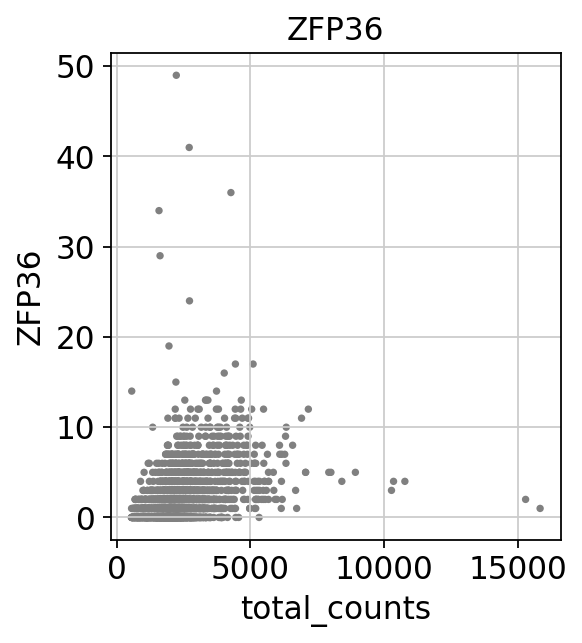

In [14]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
observe_library_size_effect(adata)

An alternative method to normalize data is using SCRAN that applies a similar principle to common normalization methods in bulk RNA data.

Here we will normalize to a total library size of 10,000. Scanpy will update our count matrix (adata.X) automatically with the normalized counts.

In [15]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=10**4)

Trying to set attribute `.obs` of view, copying.


### Data "clean-up": log-transformation

Log transformation makes changes in expression relative rather than absolute (e.g. it looks at doubling (when using log2) of expression rather than increase of n counts in expression). It makes the differences between highly and lowly expressed genes smaller, and limits the effects of highly expressed genes on your data analysis. It is often considered a default part of preprocessing, but can occasionally be better left out. The desired effect of a log-transformation is that it brings out biological differences between your cell populations better. <br>
Scanpy's log transformation function takes the natural logarithm of each (count + 1), and updates your count matrix (adata.X): 

In [16]:
sc.pp.log1p(adata)

### Data "clean-up": remove bad quality cells

🕹️ Add path to your good quality cell sample that you have stored already using Step 1.

In [17]:
sample1_QC = pd.read_pickle("files/annotated_cells/3K_PBMCs_QCpassed.pkl")

In [18]:
# concatenate samples
QC = pd.concat([sample1_QC], ignore_index=True)

💡 **Hint:** To add multiple samples repeat the code above by changing the sample's name, as shown below.

```
{
    # add name here for sample one based on the batch_categories in step 2.1.2
    sample1_QCv2 = sample1_QC + '.sample1'
    
    # repeat the code below for extra samples
    sample2_QC = pd.read_pickle("files/annotated_cells/sample2_QCpassed.pkl")
    sample2QCv2 = sample2QC + '.sample2'
    
    # concatenate samples good quality cell annotation
    QC = pd.concat([sample1_QCv2, sample2_QCv2], ignore_index=True)
}
```

Check the number of all cells for your integrated samples.

In [20]:
adata.shape

(2700, 16466)

Add good/bad quality cell annotation to a new variable in your anndata object and check the number of good quality cells that will be maintained after the filtering.

In [22]:
adata.obs['QC'] = adata.obs.index.isin(QC.iloc[:,0])

In [23]:
adata[adata.obs['QC']!=False].shape

(2426, 16466)

In [24]:
adata.obs['keep_cell'] = ['yes' if x==True else 'no' for x in adata.obs['QC']] 

In [25]:
rng = np.random.RandomState(42)
sc.tl.pca(adata, n_comps=25, svd_solver='arpack', random_state=rng)
sc.pp.neighbors(adata, n_neighbors=15)
sc.tl.umap(adata)

In [29]:
# observe good/bad quality cells annotation and assorted quality metrics on a UMAP before their removal

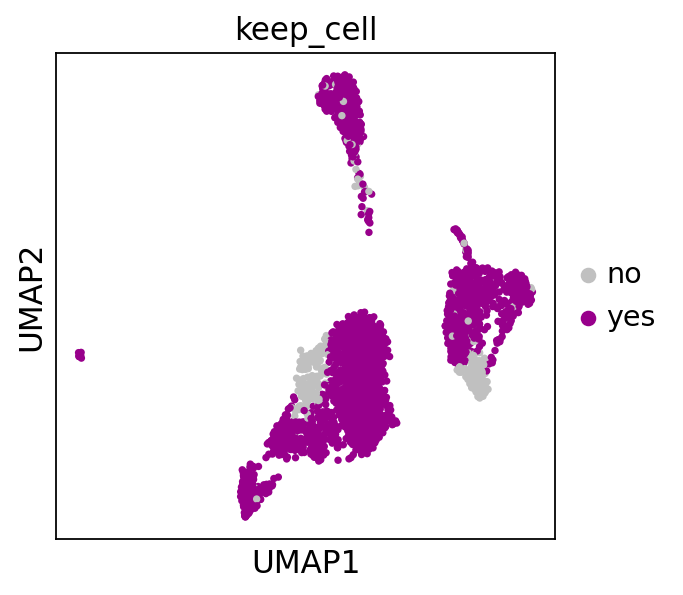

In [30]:
adata.uns['keep_cell_colors'] = [  "#C0C0C0", "#98008B"]
# quick pick at your cells to be removed
sc.pl.umap(
    adata, 
    color=['keep_cell'], 
    ncols=3,
    wspace = 0.3,
    sort_order = False
)

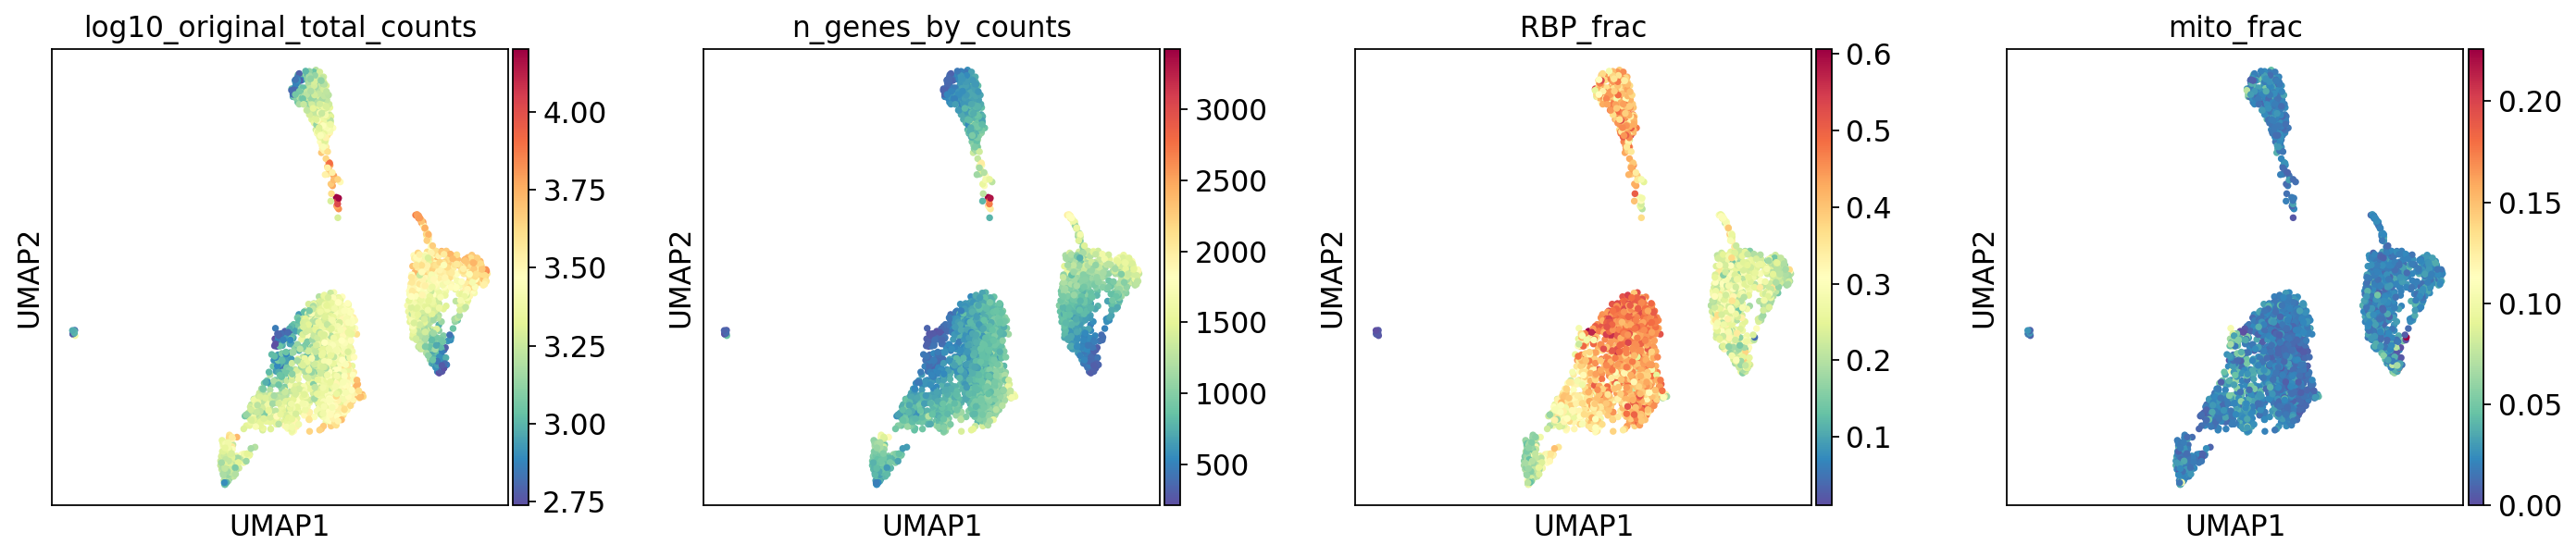

In [31]:
# inspect the QC metrics
sc.pl.umap(
    adata, 
    color=['log10_original_total_counts', 'n_genes_by_counts','RBP_frac', 'mito_frac'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

❗ This next command will remove bad quality cells.

In [32]:
adata = adata[adata.obs['QC']!=False]

### Let's have a look at the integrated data

In [33]:
rng = np.random.RandomState(42)
adata = sc.tl.pca(adata, n_comps=200, copy = True, svd_solver='arpack', random_state=rng)

We can visualize the percentage of variance explained by each PC. Based on this figure, we will select a number of principal components to use in the rest of our analysis. 

<function matplotlib.pyplot.show(close=None, block=None)>

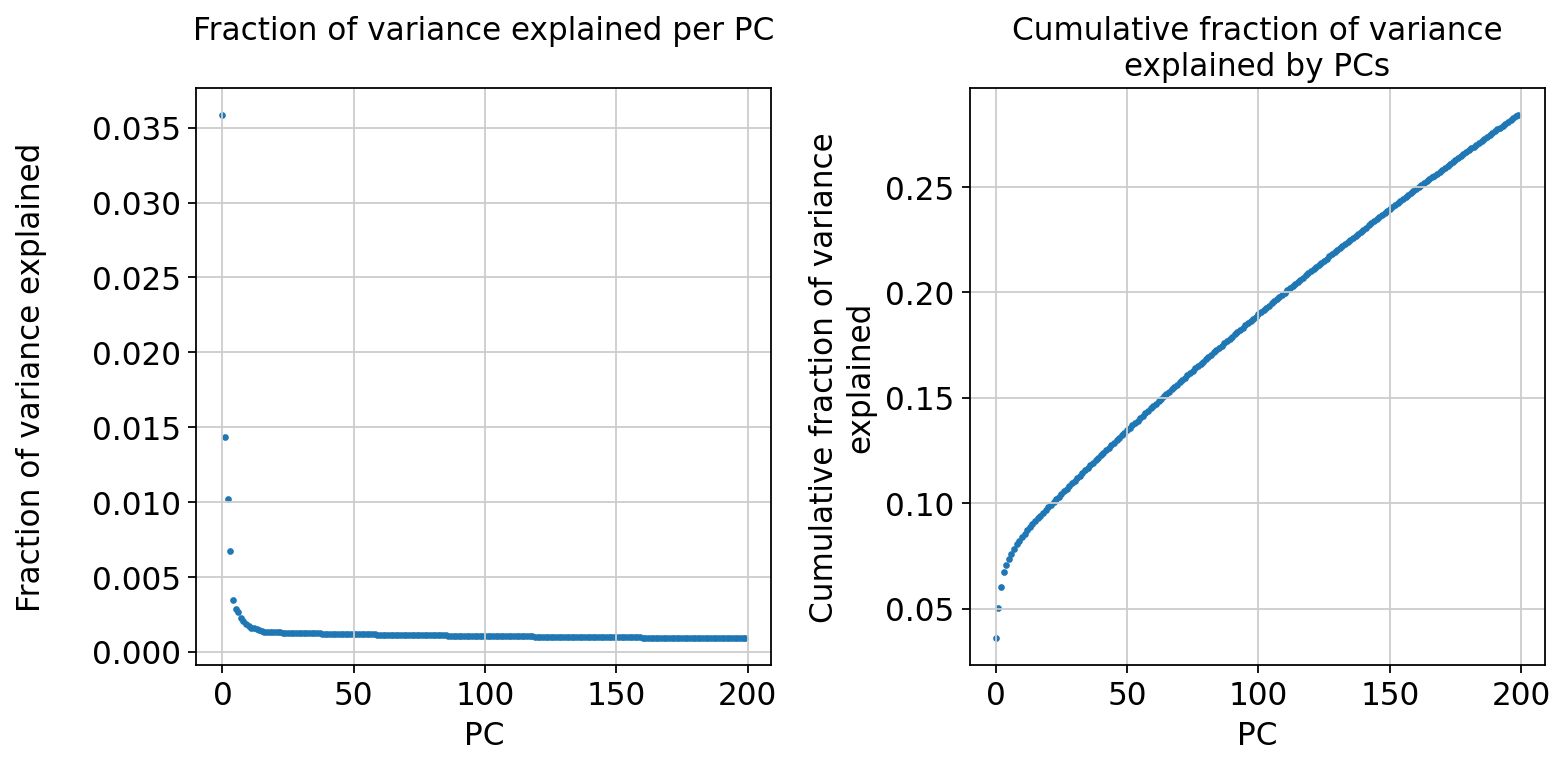

In [34]:
observe_variance(adata)

❗ We want to include all the principal components before the 'knee point' (the point where the fitted curve would change slope the most), because these likely represent important sources of variance in our data. To try to avoid eliminating any relevant but small sources of variance, we will choose a number of PCs slightly to the right of the knee point. 

Replace the number below with your selection and run PCA again.

In [35]:
rng = np.random.RandomState(42)
sc.tl.pca(adata, n_comps=25, svd_solver='arpack', random_state=rng)
sc.pp.neighbors(adata, n_neighbors=15)
sc.tl.umap(adata)

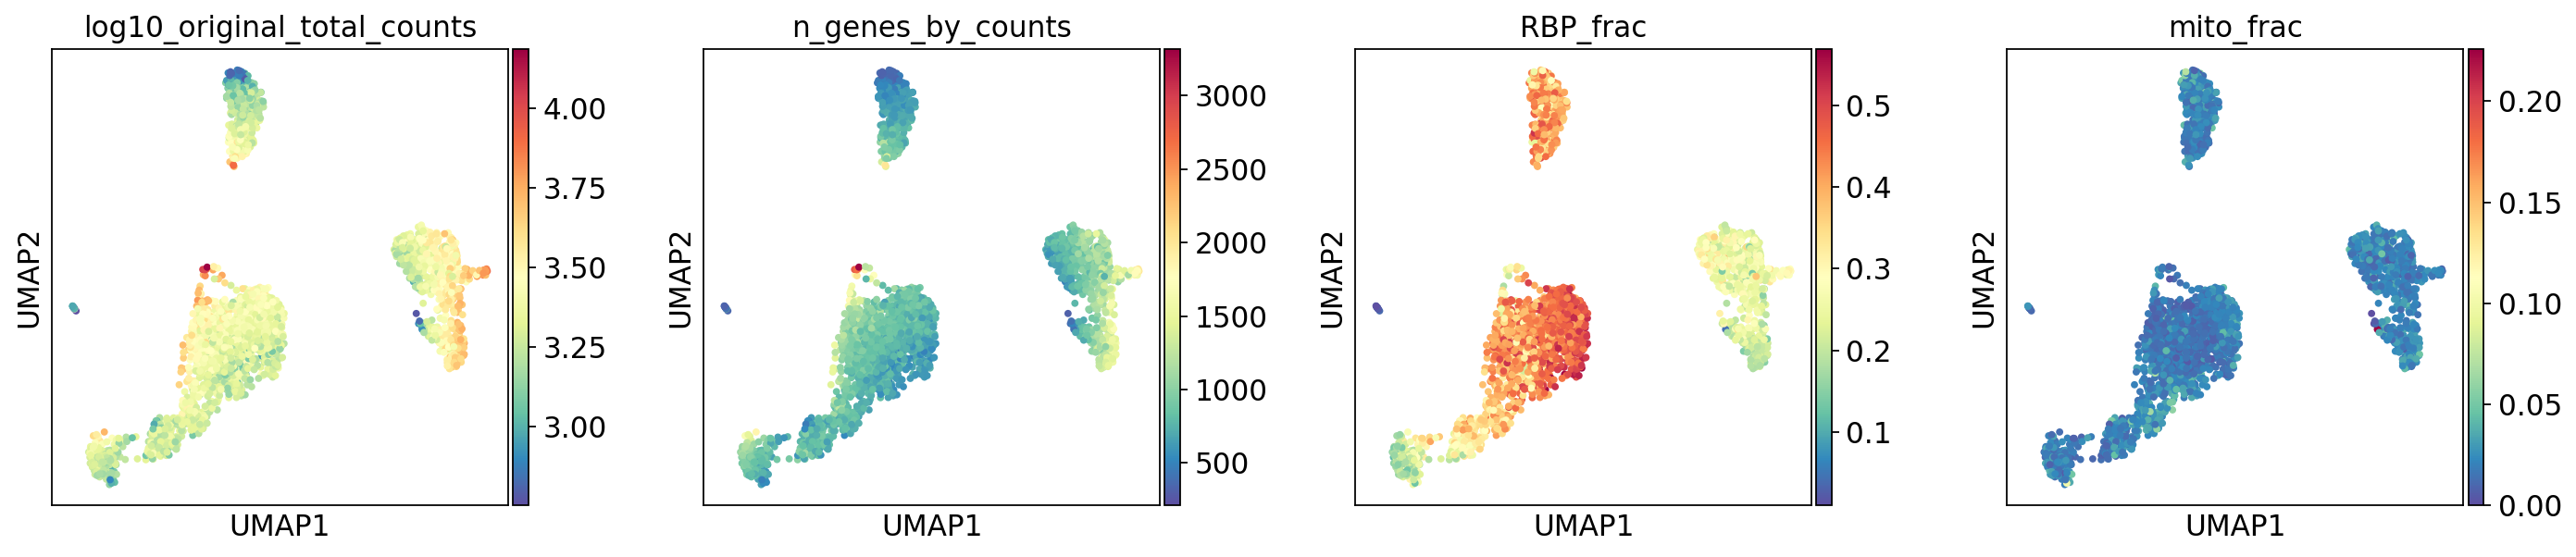

In [37]:
# inspect the QC metrics
sc.pl.umap(
    adata, 
    color=['log10_original_total_counts', 'n_genes_by_counts','RBP_frac', 'mito_frac'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

### Unsupervised clustering analysis using PhenoGraph

In [38]:
# calculate clustering characteristics for a range of ks (5 to 155), by a step of 5.
ks = np.arange(5,155,5)
cluster_chars = [calc_clustering_characteristics(k, adata.obsm['X_pca']) for k in ks];

Finding 5 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.19324612617492676 seconds
Jaccard graph constructed in 4.806628942489624 seconds
Wrote graph to binary file in 0.00985264778137207 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.908977
Louvain completed 21 runs in 2.3861327171325684 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 12.459187507629395 seconds
Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.18394780158996582 seconds
Jaccard graph constructed in 4.7246434688568115 seconds
Wrote graph to binary file in 0.0211641788482666 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.843053
After 2 runs, maximum modularity is Q = 0.844245
After 3 runs, maximum modularity is Q = 0.846069
Louvain completed 23 runs in 3.2544400691986084 seconds
Sorting communities by size, please wait ...


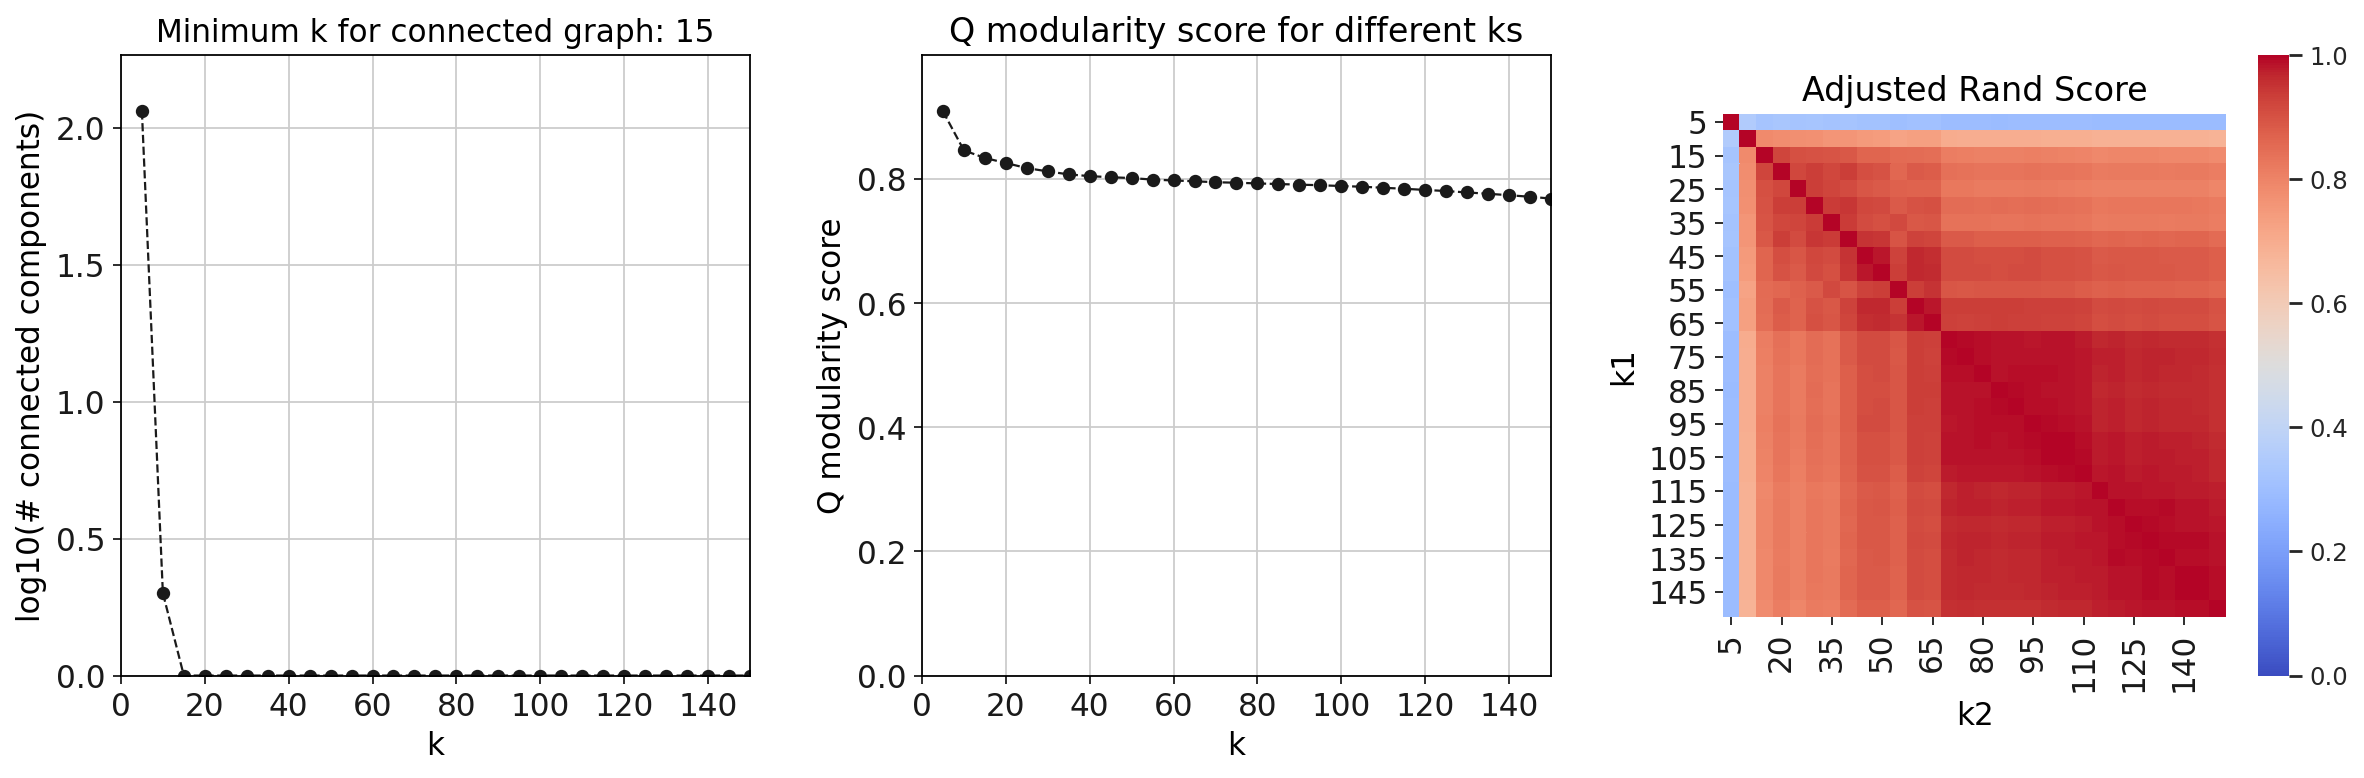

In [39]:
Rand_index_df = inspect_clustering_chars(ks, cluster_chars)

In [40]:
Rand_index_df.iloc[1:5,1:10]

k2        10        15        20        25        30        35        40  \
k1                                                                         
10  1.000000  0.787255  0.779644  0.774293  0.773398  0.759107  0.760379   
15  0.787255  1.000000  0.923543  0.905382  0.900952  0.897664  0.887124   
20  0.779644  0.923543  1.000000  0.921080  0.934175  0.921514  0.935009   
25  0.774293  0.905382  0.921080  1.000000  0.936795  0.924407  0.913927   

k2        45        50  
k1                      
10  0.746505  0.745098  
15  0.866144  0.863797  
20  0.906369  0.899827  
25  0.891201  0.885653

In [41]:
# add your selected k value here to proceed
k=15
communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata.obsm['X_pca']),k=k)
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.1932055950164795 seconds
Jaccard graph constructed in 8.533844470977783 seconds
Wrote graph to binary file in 0.038764238357543945 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.832175
After 5 runs, maximum modularity is Q = 0.833797
Louvain completed 25 runs in 4.179245233535767 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 19.019461393356323 seconds


We can visualize the clustering to see which clusters match with the cells that we would like to filter out. Inspect the list of QC metrics and canonical markers to make your choice.

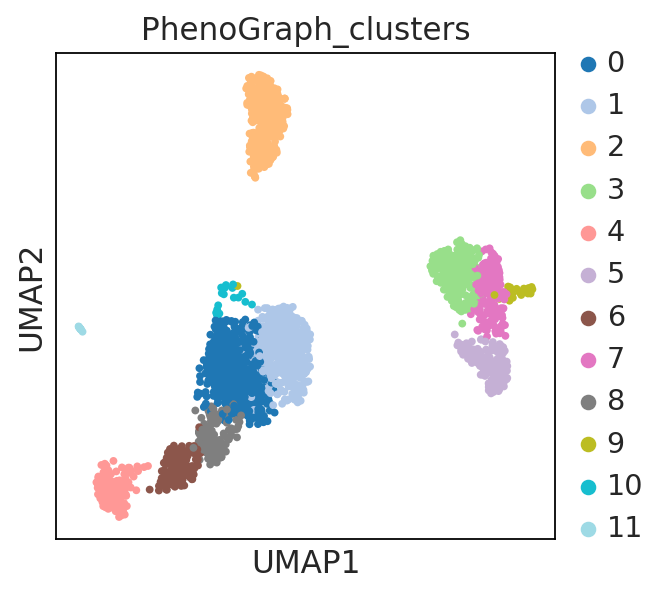

In [42]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.5,
    sort_order = False
)

You are done! Just save your integrated file as an h5ad object. Make sure your path ends with the desired filename including the .h5ad file extension. You can now come back to this dataset at anytime.

In [139]:
path_to_h5ad = 'files/anndata_objects/shunpiker_combined-samples.h5ad'

In [45]:
adata.write(path_to_h5ad)

In [140]:
adata = sc.read_h5ad(path_to_h5ad)

**Well done!** You have reached the end of Step 2.

Return to the beginning of this notebook <a href='#contents'>here</a>.

<a id='part_3'></a>

## Data visualization

This part explores options for data visualization for canonical marker genes, differentially expressed genes and other genes of interest. We provide here two very common types of plots to observe gene expression in scRNA-seq data. For more visualization optios, please see scanpy's `Core plotting functions` [tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/plotting/core.html).

🕹️ To start plotting, first add a list with your genes of interest here. 

In the example below we use an extended list of canonical markers for the PBMC dataset to in an effort to identify the identity of each of our clusters.

In [141]:
marker_genes = [ 'PTPRC', 'CD3E', 'IL7R', 'CCR7', 'S100A4', 'NKG7',  "GNLY","CD8A",  "FCER1A", "FCGR3A", "LYZ",'CD68',   "CD14",   "MS4A1", "PPBP"]

💡 **Hint:** Individual gene names need to be in single quotes and separated by commas as shown below. 

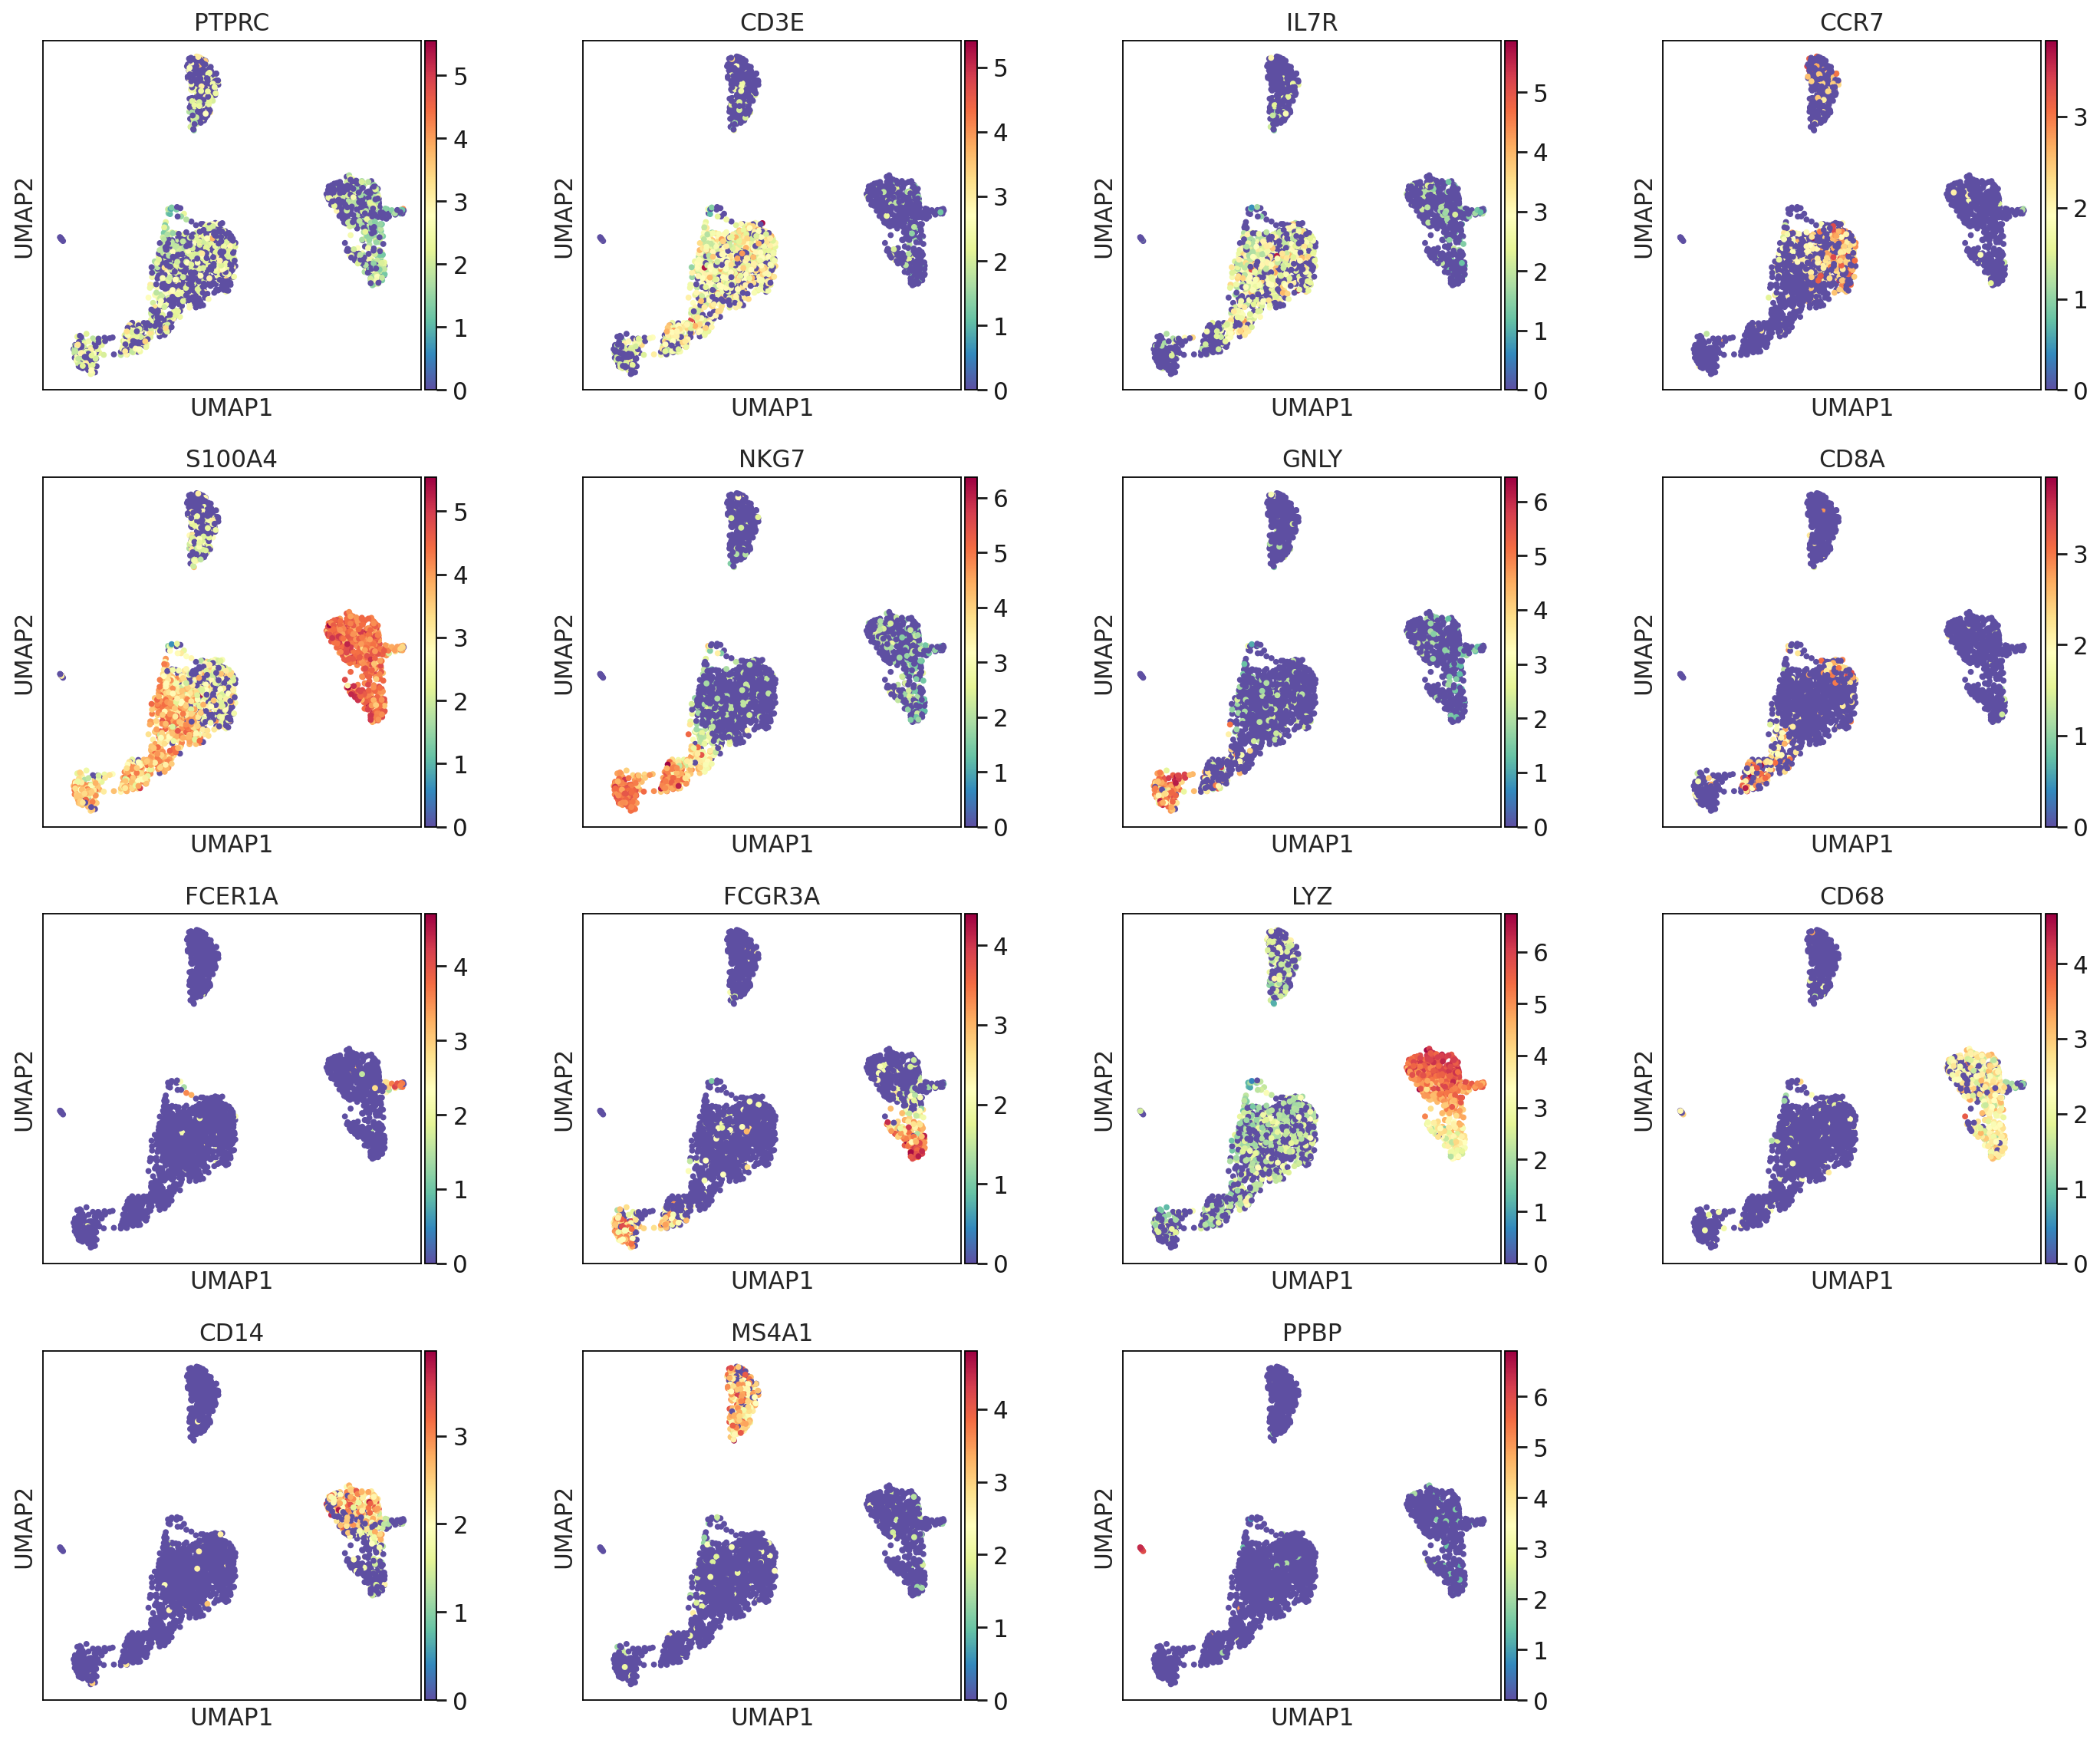

In [142]:
sc.pl.umap(
    adata, 
    color=marker_genes, 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

The plotting functions also require a grouping factor. In the examples below we are using the PhenoGraph_clusters as the group for plotting purposes. This can be replaced by any other grouping factor that has been applied in the data. See section 3.3 on how to create a grouping factor.

In [143]:
adata.obs['PhenoGraph_clusters'] =  adata.obs['PhenoGraph_clusters'].astype(str)

### Stacked violin plot

Scanpy's stacked violin plotting function creates violin plots for each of the genes of interest. Check `scanpy.pl.stacked_violin` [man page](https://scanpy.readthedocs.io/en/latest/generated/scanpy.pl.stacked_violin.html?highlight=sc.pl.stacked_violin) for a list of parameters and types of input.

/home/kousaa/miniconda3/envs/scanpy_1.8.1/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'PhenoGraph_clusters' as categorical


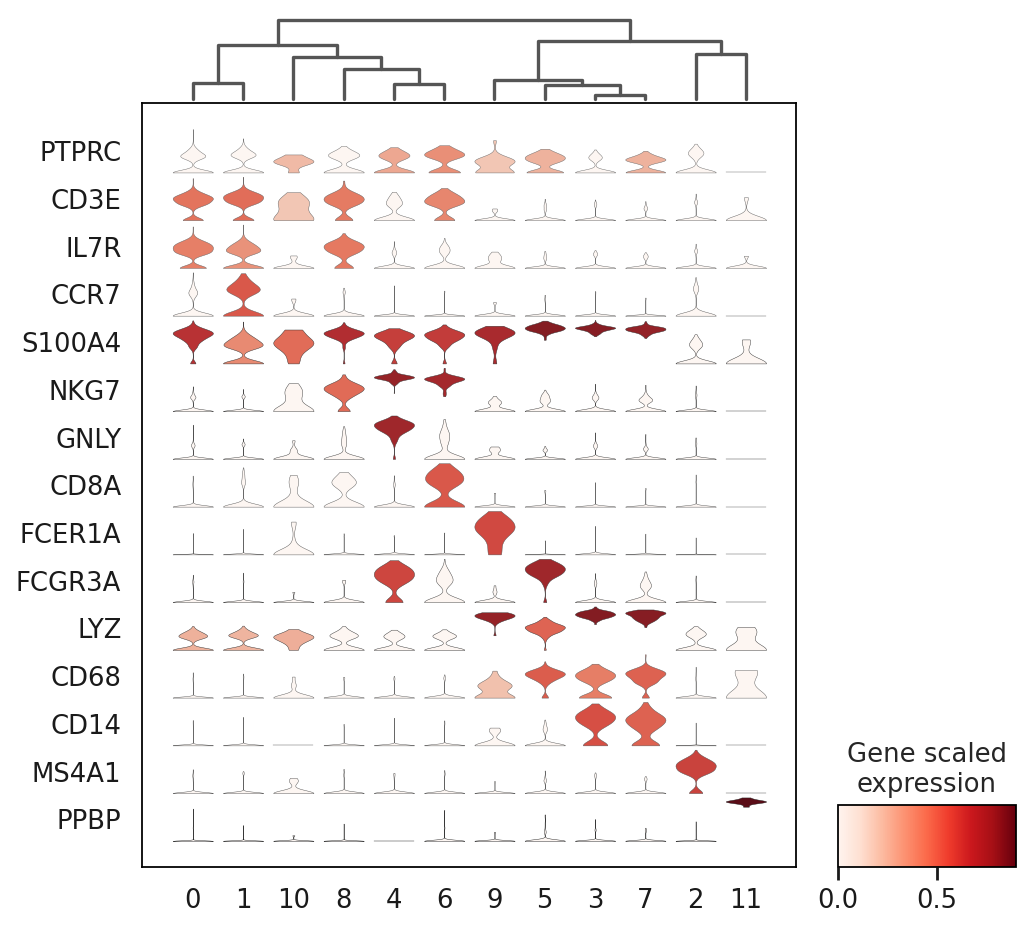

In [144]:
sc.pl.stacked_violin(adata, marker_genes, 'PhenoGraph_clusters', swap_axes=True, standard_scale='var', cmap='Reds', figsize=(7,7), dendrogram=True, colorbar_title='Gene scaled\nexpression') 

### Heatmap

Scanpy's heatmap plotting function creates violin plots for each of the genes of interest. Check `scanpy.pl.heatmap` [man page](https://scanpy.readthedocs.io/en/latest/generated/scanpy.pl.heatmap.html#scanpy-pl-heatmap) for a list of parameters and types of input.

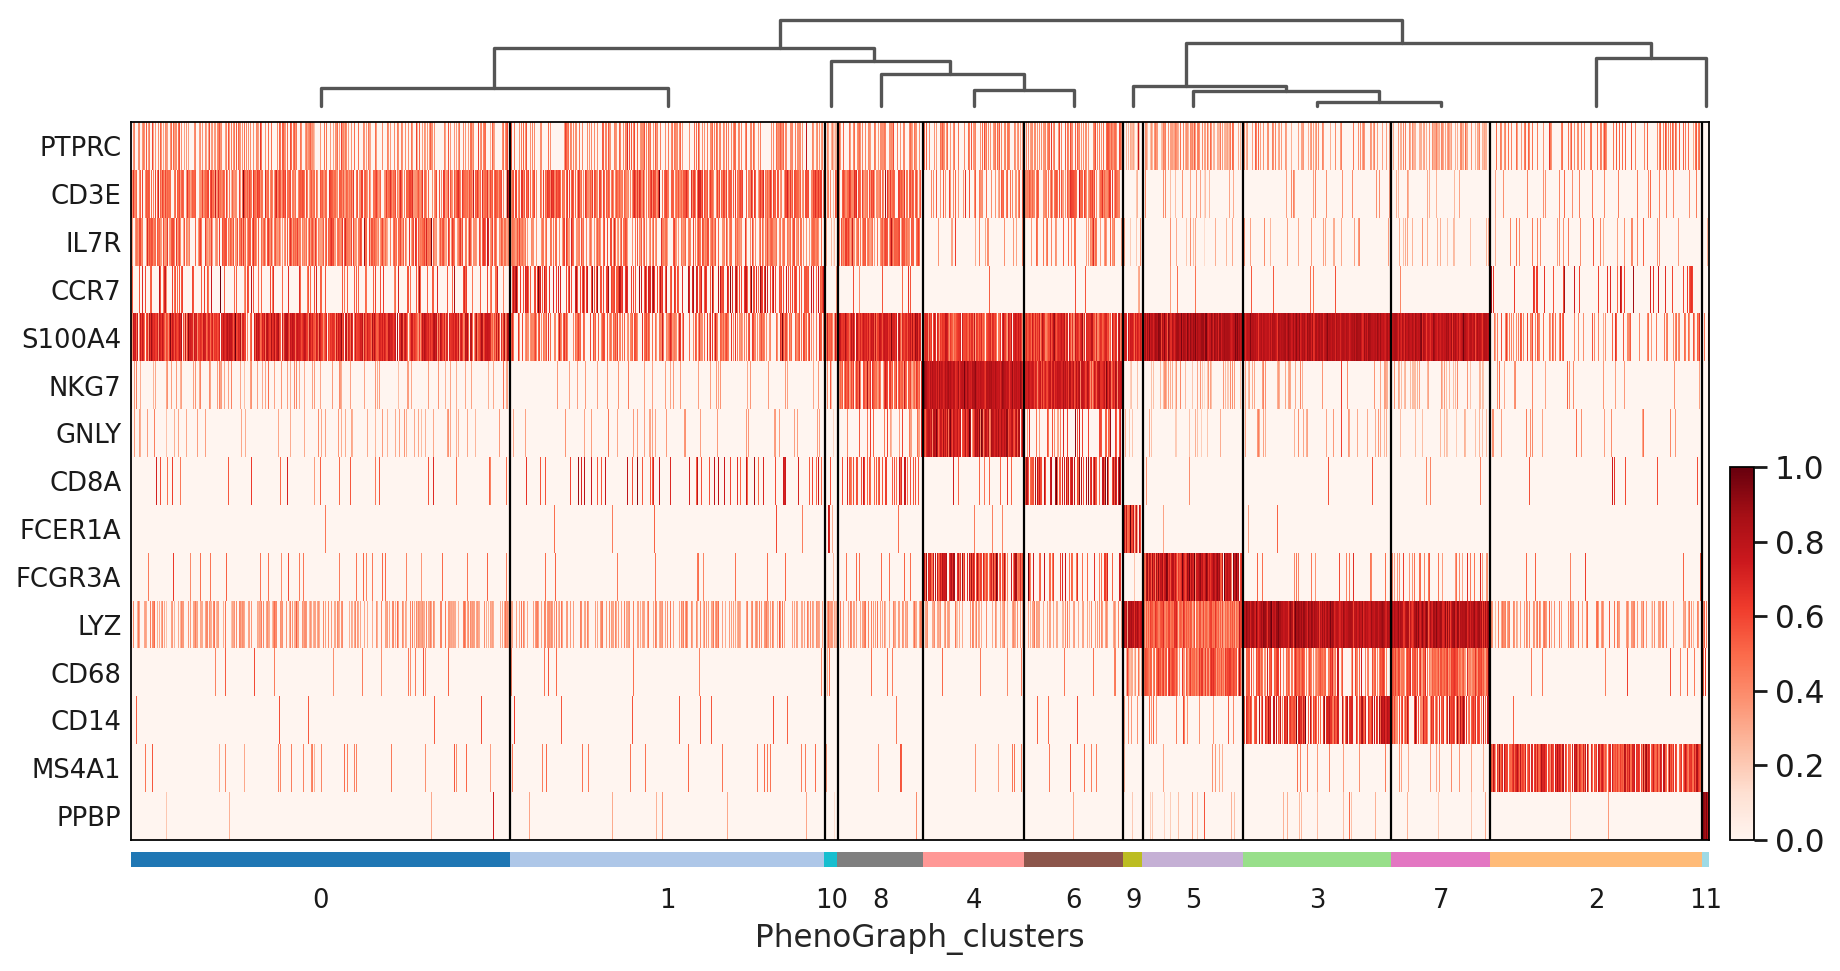

In [145]:
ax = sc.pl.heatmap(adata, marker_genes, groupby='PhenoGraph_clusters', figsize=(13, 7), cmap='Reds', standard_scale='var', dendrogram=True, swap_axes=True)

### Create group annotation

Based on the canonical markers we inspected above we can go ahead and rename our PhenoGraph clusters into the appropriate cell type and use these groupings downstream for data visualization and other analysis.

In [146]:
adata.obs['cell_type'] = ['Platelets' if (x=='11') else 'DCs' if (x=='9') else 'NKs' if (x=='4') else 'FCGR3A+ Monocytes' if (x=='5') else 'CD8+ T cells' if (x=='6' or x=='8') else 'B cells' if (x=='2') else 'Memory CD4 cells' if (x=='0' or x=='10') else 'Naive CD4 cells' if (x=='1') else 'CD14+ Mono' if (x=='3' or x=='7') else 'ERROR' for x in adata.obs['PhenoGraph_clusters']] 

In [ ]:
sc.pl.umap(
    adata, 
    color=['cell_type'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

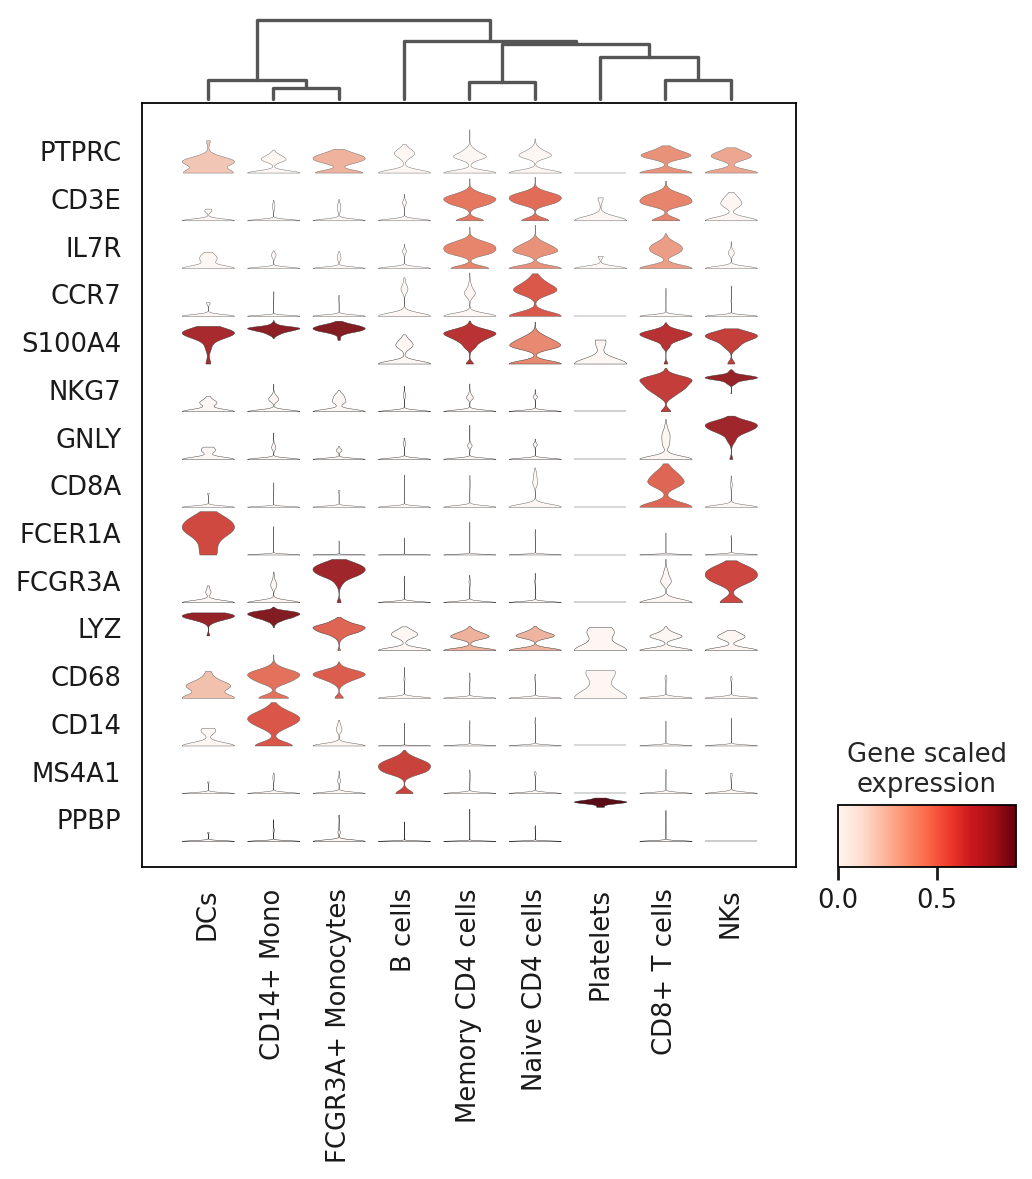

In [148]:
# violin plot example with cell type annotation
sc.pl.stacked_violin(adata, marker_genes, 'cell_type', swap_axes=True, standard_scale='var', cmap='Reds', dendrogram=True, figsize=(7,7), colorbar_title='Gene scaled\nexpression') 

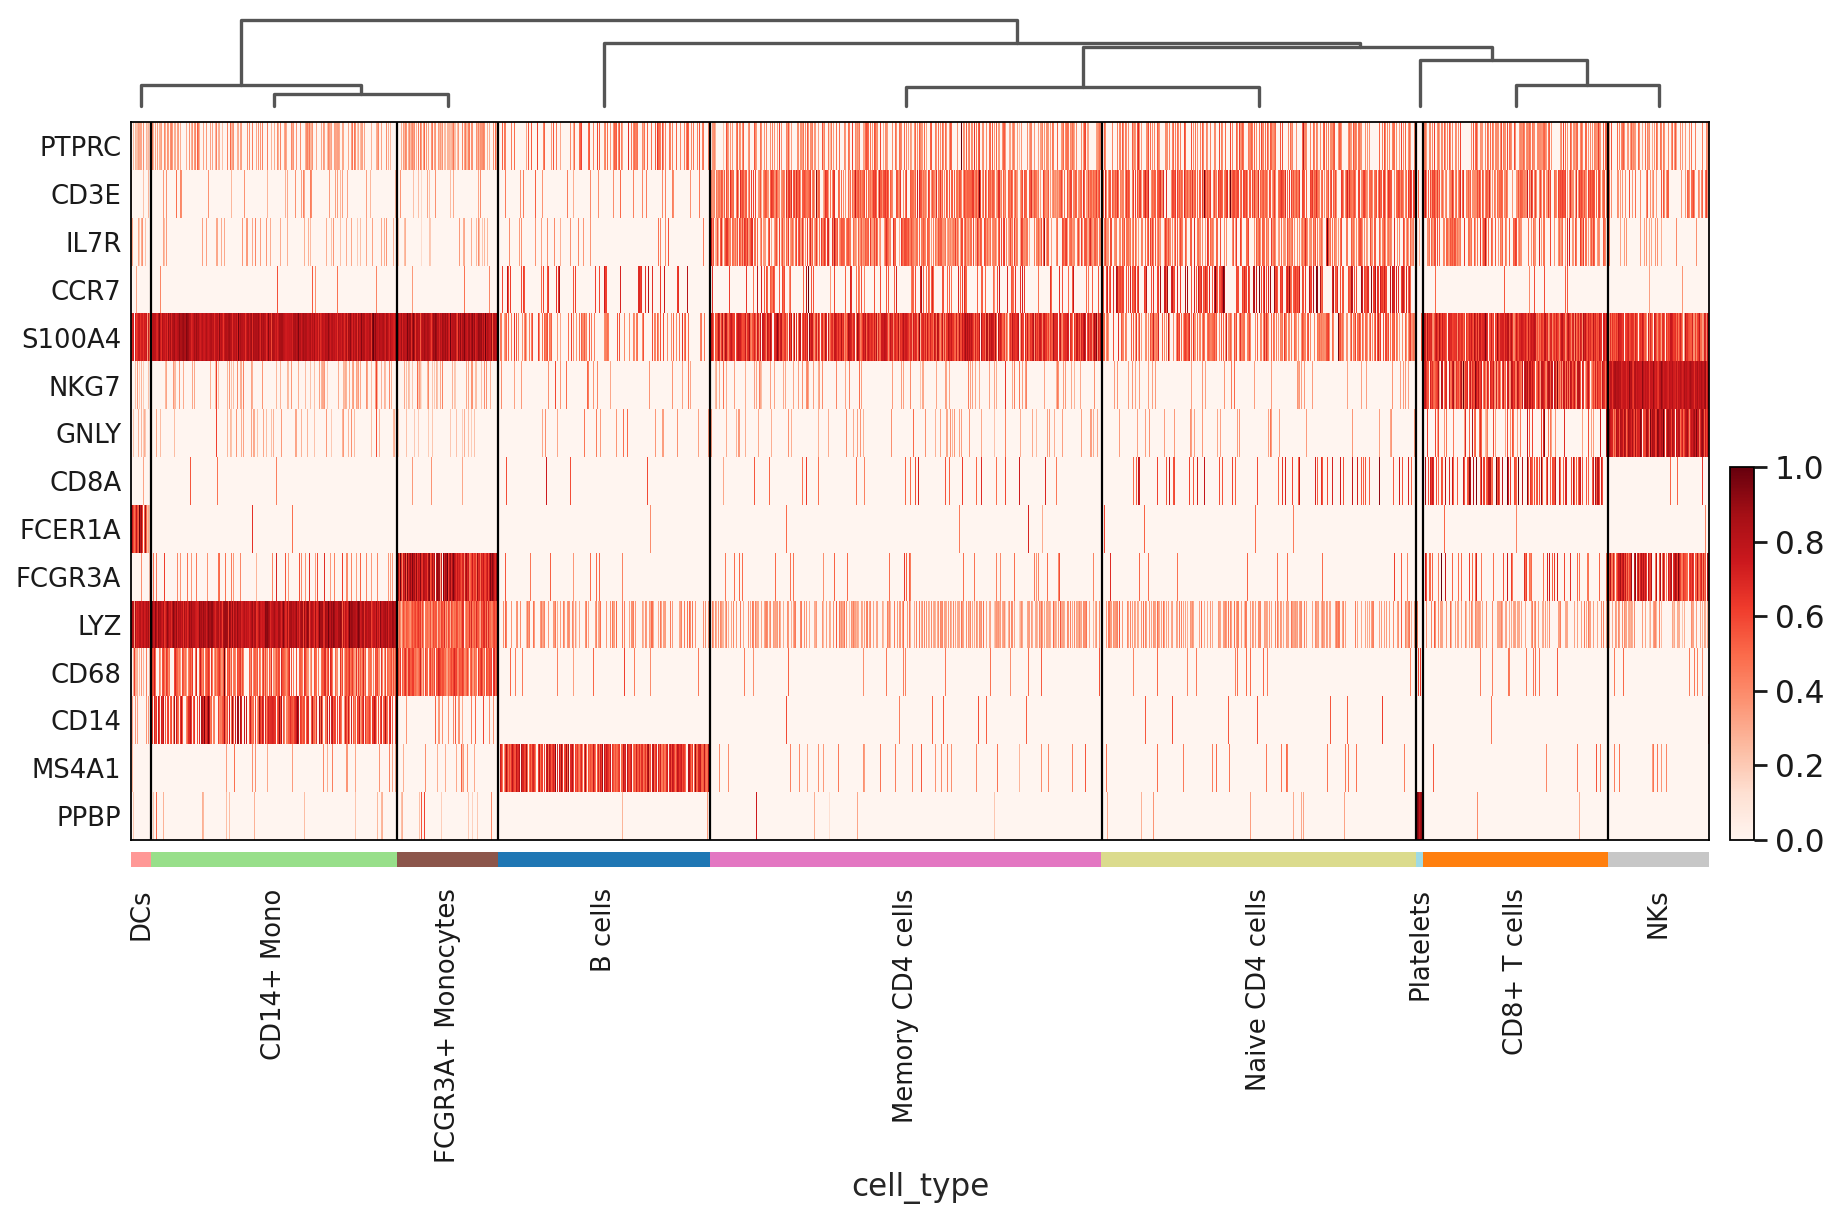

In [150]:
# heatmap example with cell type annotation
ax = sc.pl.heatmap(adata, marker_genes, groupby='cell_type', figsize=(13,7), cmap='Reds', standard_scale='var', dendrogram=True, swap_axes=True)

**Well done!** You have reached the end of Step 3.

Return to the beginning of this notebook <a href='#contents'>here</a>.

<a id='part_4'></a>

## Differential gene expression analysis

### Wilcoxon test

https://www.nature.com/articles/nmeth.4612

In [151]:
sc.tl.rank_genes_groups(adata, 'cell_type', method='wilcoxon')

In [152]:
# top 5 differentially expressed genes for each cell type. Change number in brackets to get a more extended gene list
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

B cells CD8+ T cells CD14+ Mono       DCs FCGR3A+ Monocytes  \
0      CD74         CCL5        LYZ  HLA-DRB1              LST1   
1   HLA-DRA         NKG7     S100A9  HLA-DPB1            FCER1G   
2     CD79A         CST7     TYROBP  HLA-DPA1              AIF1   
3  HLA-DPB1         GZMA     S100A8      CST3            FCGR3A   
4     CD79B          B2M       FCN1  HLA-DRB5             COTL1   

  Memory CD4 cells   NKs Naive CD4 cells Platelets  
0             IL32  GNLY          MALAT1     SPARC  
1              LTB  NKG7            LDHB      PPBP  
2             LDHB  GZMB          EEF1A1     GNG11  
3             IL7R  PRF1            TPT1       PF4  
4             CD3D  CTSW            NPM1      SDPR

Using the plotting function below scanpy allows to visualize the results.

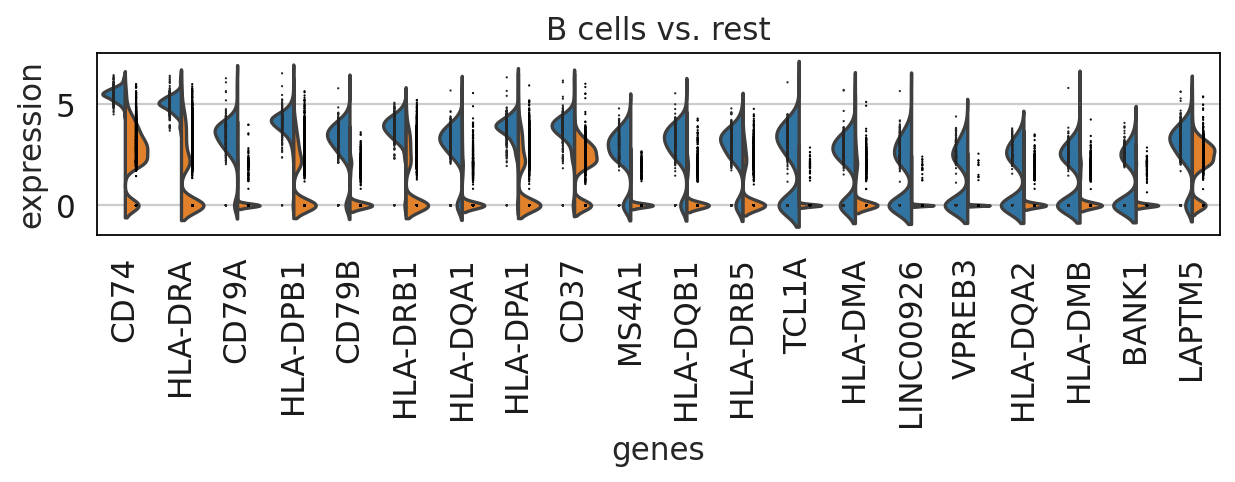

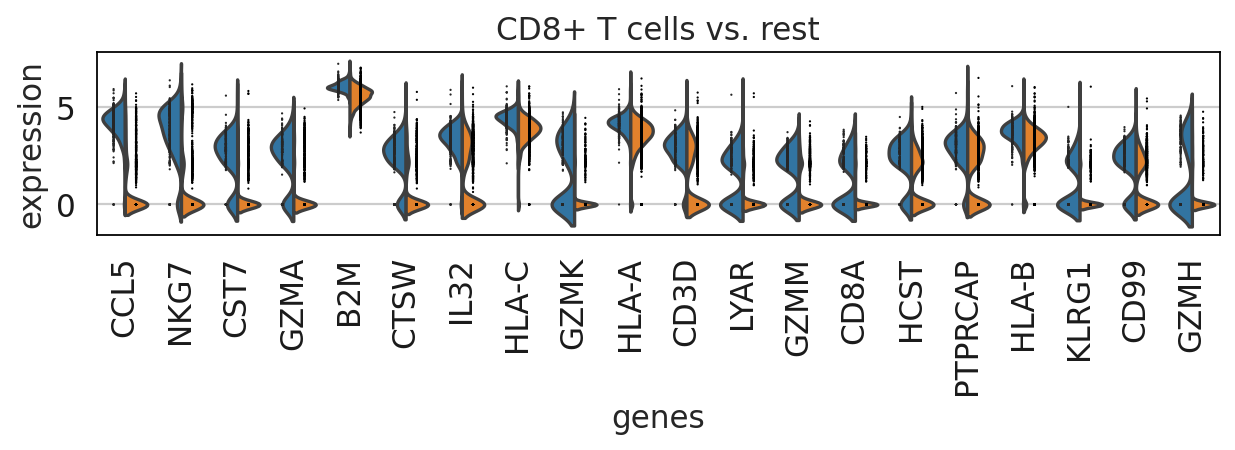

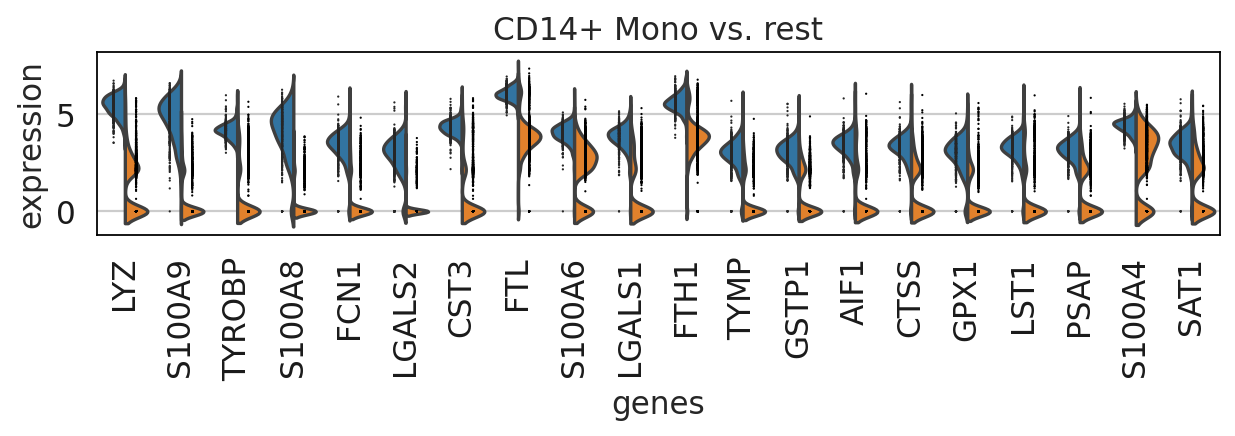

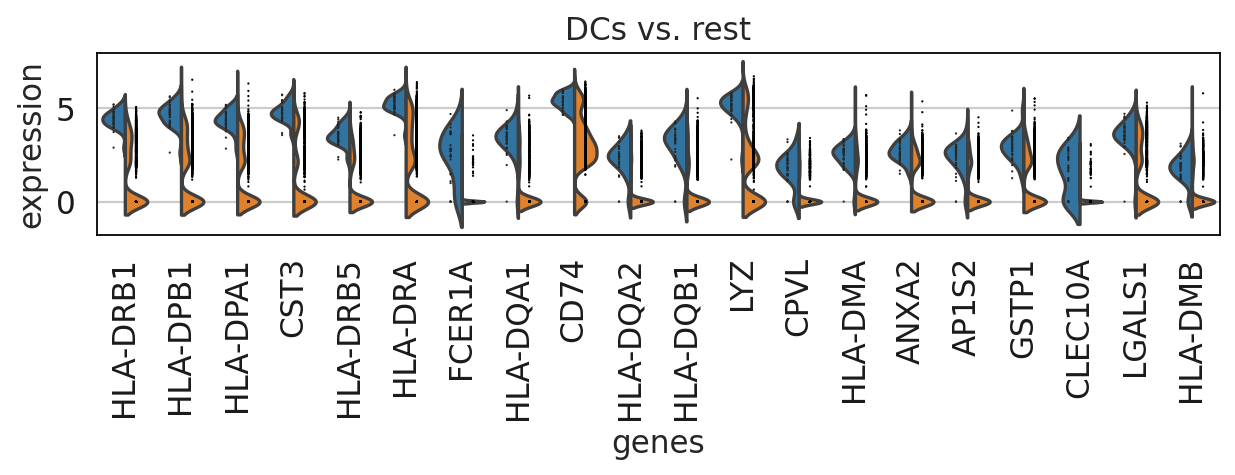

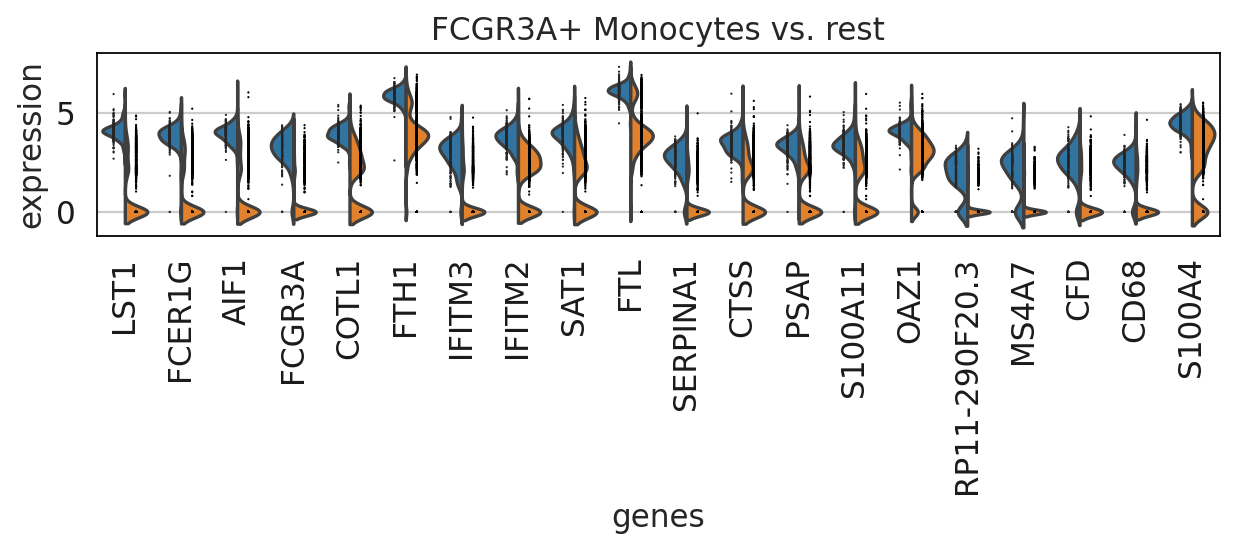

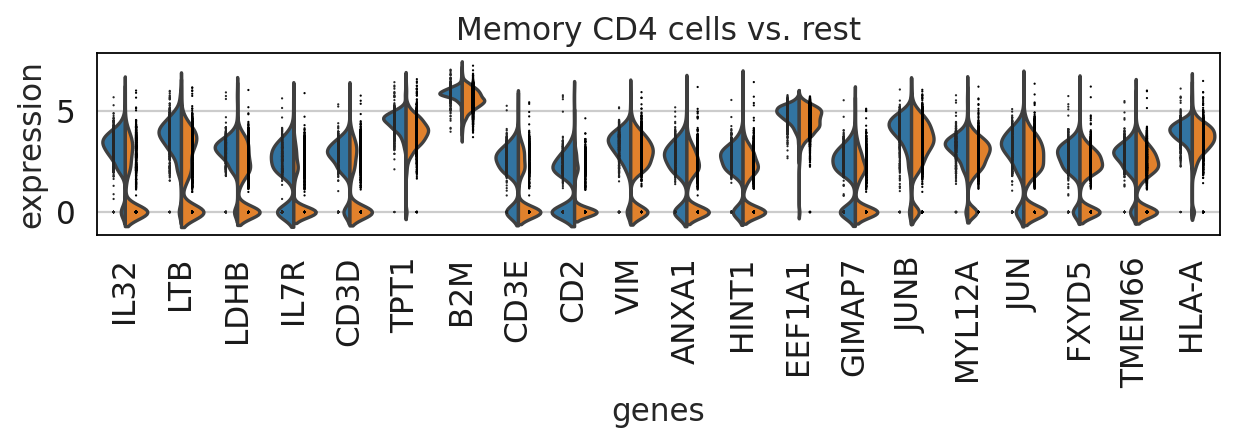

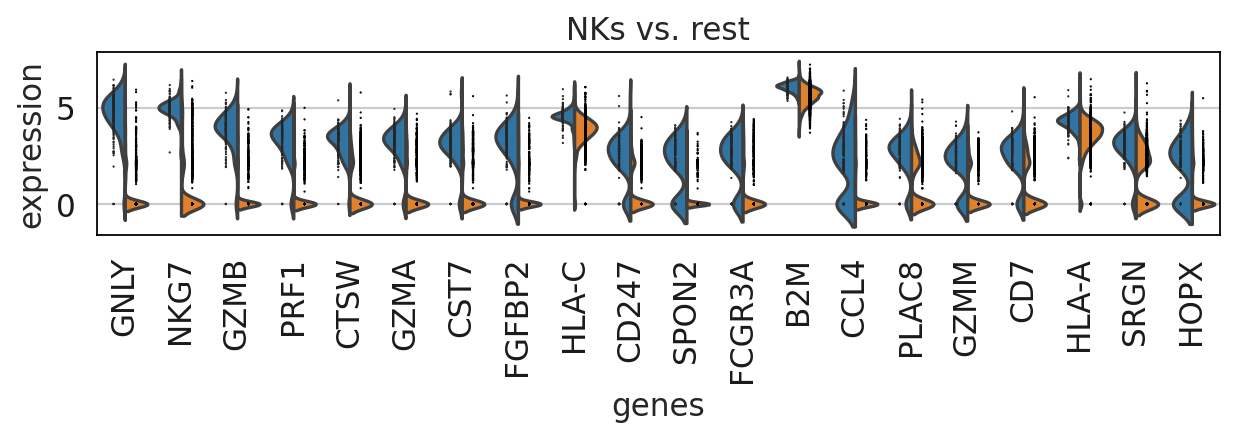

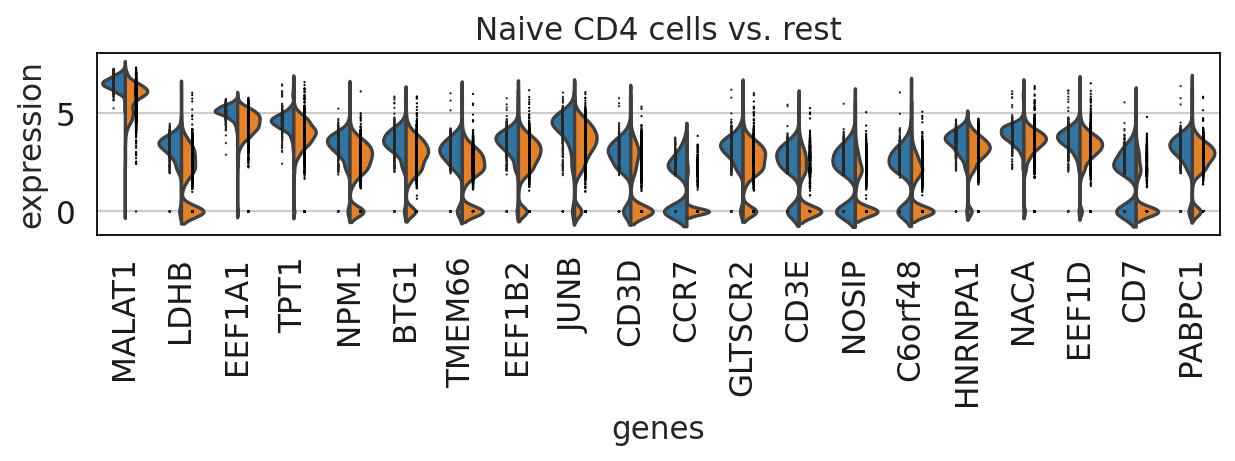

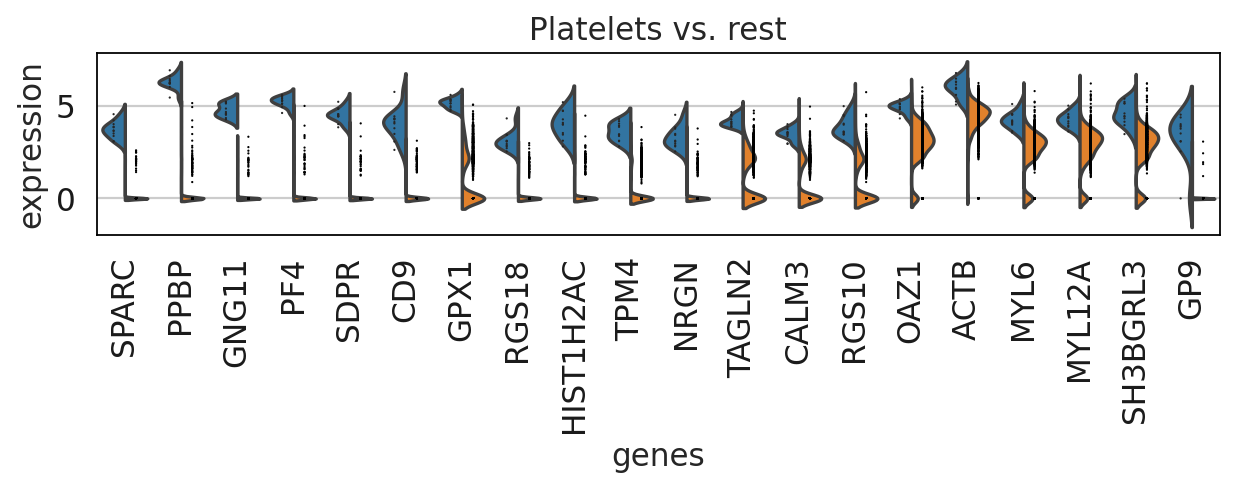

In [153]:
from matplotlib.pyplot import rc_context

with rc_context({'figure.figsize': (9, 1.5)}):
    sc.pl.rank_genes_groups_violin(adata, n_genes=20, jitter=False)

### MAST

A more well suited differential expression tool is MAST. Use the commands below to generate count and metadata files. You can then adjust the R example code below to run the differential expression analysis with MAST.

In [154]:
counts = pd.DataFrame(adata.X)
counts.index = adata.obs.index.values
counts = np.transpose(counts)
counts.index = adata.var.index.values
counts.to_csv('files/mast_items/test_counts.txt', sep='\t', header = True, index=True)

In [155]:
counts = np.transpose(counts)
counts.insert(0, 'cell_type', adata.obs['cell_type'])

In [156]:
counts.iloc[:,0].to_csv('files/mast_items/test_metadata.txt', sep='\t', header = True, index=True)

Use now generated files to run the differential expression analysis with the R code below.

In [157]:
%load_ext rpy2.ipython

In [158]:
%R if (!require("pacman")) install.packages("pacman")
%R pacman::p_load(MAST, data.table, openxlsx, ggplot2, ggpubr, RColorBrewer, dichromat)

R[write to console]: Loading required package: pacman



<rpy2.robjects.vectors.BoolVector object at 0x2b87a2f7ff40> [RTYPES.LGLSXP]
R classes: ('logical',)
[       1,        1,        1,        1,        1,        1,        1]

In [181]:
%R counts = read.csv('files/mast_items/test_counts.txt', sep = '\t', row.names=1, header=TRUE)

AAACATACAACCAC.1  AAACATTGAGCTAC.1  AAACATTGATCAGC.1  \
AL627309.1                  0.0               0.0               0.0   
AP006222.2                  0.0               0.0               0.0   
RP11-206L10.2               0.0               0.0               0.0   
RP11-206L10.9               0.0               0.0               0.0   
FAM87B                      0.0               0.0               0.0   
...                         ...               ...               ...   
AC011841.1                  0.0               0.0               0.0   
AL354822.1                  0.0               0.0               0.0   
KIR2DL2                     0.0               0.0               0.0   
PNRC2-1                     0.0               0.0               0.0   
SRSF10-1                    0.0               0.0               0.0   

               AAACCGTGCTTCCG.1  AAACCGTGTATGCG.1  AAACGCACTGGTAC.1  \
AL627309.1                  0.0               0.0               0.0   
AP006222.2                  0.0               0.0               0.0   
RP11-206L10.2               0.0               0.0               0.0   
RP11-206L10.9               0.0               0.0               0.0   
FAM87B                      0.0               0.0               0.0   
...                         ...               ...               ...   
AC011841.1                  0.0               0.0               0.0   
AL354822.1                  0.0               0.0               0.0   
KIR2DL2                     0.0               0.0               0.0   
PNRC2-1                     0.0               0.0               0.0   
SRSF10-1                    0.0               0.0               0.0   

               AAACGCTGACCAGT.1  AAACGCTGGTTCTT.1  AAACGCTGTTTCTG.1  \
AL627309.1                  0.0               0.0               0.0   
AP006222.2                  0.0               0.0               0.0   
RP11-206L10.2               0.0               0.0               0.0   
RP11-206L10.9               0.0               0.0               0.0   
FAM87B                      0.0               0.0               0.0   
...                         ...               ...               ...   
AC011841.1                  0.0               0.0               0.0   
AL354822.1                  0.0               0.0               0.0   
KIR2DL2                     0.0               0.0               0.0   
PNRC2-1                     0.0               0.0               0.0   
SRSF10-1                    0.0               0.0               0.0   

               AAACTTGAAAAACG.1  ...  TTTCACGAGGTTCA.1  TTTCAGTGGAAGGC.1  \
AL627309.1                  0.0  ...               0.0               0.0   
AP006222.2                  0.0  ...               0.0               0.0   
RP11-206L10.2               0.0  ...               0.0               0.0   
RP11-206L10.9               0.0  ...               0.0               0.0   
FAM87B                      0.0  ...               0.0               0.0   
...                         ...  ...               ...               ...   
AC011841.1                  0.0  ...               0.0               0.0   
AL354822.1                  0.0  ...               0.0               0.0   
KIR2DL2                     0.0  ...               0.0               0.0   
PNRC2-1                     0.0  ...               0.0               0.0   
SRSF10-1                    0.0  ...               0.0               0.0   

               TTTCAGTGTCACGA.1  TTTCAGTGTGCAGT.1  TTTCCAGAGGTGAG.1  \
AL627309.1                  0.0               0.0          0.000000   
AP006222.2                  0.0               0.0          0.000000   
RP11-206L10.2               0.0               0.0          0.000000   
RP11-206L10.9               0.0               0.0          0.000000   
FAM87B                      0.0               0.0          0.000000   
...                         ...               ...               ...   
AC011841.1                  0.0               

In [182]:
%R meta = read.csv('files/mast_items/test_metadata.txt', sep = '\t', row.names=1,  header=TRUE)

cell_type
AAACATACAACCAC-1      CD8+ T cells
AAACATTGAGCTAC-1           B cells
AAACATTGATCAGC-1  Memory CD4 cells
AAACCGTGCTTCCG-1        CD14+ Mono
AAACCGTGTATGCG-1               NKs
...                            ...
TTTCGAACTCTCAT-1        CD14+ Mono
TTTCTACTGAGGCA-1  Memory CD4 cells
TTTCTACTTCCTCG-1           B cells
TTTGCATGAGAGGC-1           B cells
TTTGCATGCCTCAC-1   Naive CD4 cells

[2426 rows x 1 columns]

In [183]:
%R dataset = list(t(counts), meta)
%R names(dataset) <- c("counts", "meta")

<rpy2.robjects.vectors.StrVector object at 0x2b87a2c1b9c0> [RTYPES.STRSXP]
R classes: ('character',)
['counts', 'meta']

In [184]:
# load data into MAST object
%R sca <- FromMatrix(t(dataset$counts), dataset$meta) 
%R sca

R[write to console]: `cData` has no wellKey.  I'll make something up.

R[write to console]: Assuming data assay in position 1, with name et is log-transformed.



<rpy2.robjects.methods.RS4 object at 0x2b87a3753ac0> [RTYPES.S4SXP]
R classes: ('SingleCellAssay',)

In [185]:
# calculate and store the cdr per cell
%R cdr2 <-colSums(assay(sca)>0)
%R colData(sca)$cngeneson <- scale(cdr2)

array([[-0.39263854],
       [ 1.8036885 ],
       [ 0.97660318],
       ...,
       [-1.00602718],
       [-1.65107458],
       [-0.61424992]])

In [186]:
%R colData(sca)$cell_type = as.factor(colData(sca)$cell_type)

['CD8+ T cells', 'B cells', 'Memory CD4 cells', 'CD14+ Mono', 'NKs', ..., 'CD14+ Mono', 'Memory CD4 cells', 'B cells', 'B cells', 'Naive CD4 cells']
Length: 2426
Categories (9, object): ['B cells', 'CD14+ Mono', 'CD8+ T cells', 'DCs', ..., 'Memory CD4 cells', 'Naive CD4 cells', 'NKs', 'Platelets']

In [187]:
# check cluster levels
%R levels(colData(sca)$cell_type)

<rpy2.robjects.vectors.StrVector object at 0x2b87a3baeac0> [RTYPES.STRSXP]
R classes: ('character',)
['B cells', 'CD14+ Mo..., 'CD8+ T c..., 'DCs', ..., 'Memory C..., 'Naive CD..., 'NKs', 'Platelets']

In [188]:
%R DE_list = list()

<rpy2.robjects.vectors.ListVector object at 0x2b87a3b87c00> [RTYPES.VECSXP]
R classes: ('list',)
[]

In [189]:
%R step =0;
%R colData(sca)$comparison = colData(sca)$cell_type

['CD8+ T cells', 'B cells', 'Memory CD4 cells', 'CD14+ Mono', 'NKs', ..., 'CD14+ Mono', 'Memory CD4 cells', 'B cells', 'B cells', 'Naive CD4 cells']
Length: 2426
Categories (9, object): ['B cells', 'CD14+ Mono', 'CD8+ T cells', 'DCs', ..., 'Memory CD4 cells', 'Naive CD4 cells', 'NKs', 'Platelets']

In [190]:
length = %R length(levels(colData(sca)$cell_type))

In [3]:
%%R for (x in 1:length(levels(colData(sca)$cell_type))){
    #reset the original clusters' order for each run
    colData(sca)$comparison = colData(sca)$cell_type
    #replace levels with the cluster of interest vs REST
    levels(colData(sca)$comparison) = c(rep('REST', step), levels(colData(sca)$comparison)[x] , rep('REST', 9-step))
    #make sure REST is the reference group (denominator)
    comp<-factor(colData(sca)$comparison)
    comp<-relevel(comp,"REST")
    colData(sca)$comparison<-comp
    
    zlmComp <- zlm(~comparison + cngeneson, sca)
    subsetComp = paste('comparison', levels(colData(sca)$comparison)[2], sep="")
    summaryComp <- summary(zlmComp, doLRT=subsetComp) 
    summaryCmp <- summaryComp$datatable
    #hurdle P values
    fcHurdle <- merge(summaryCmp[contrast==subsetComp & component=='H',.(primerid, `Pr(>Chisq)`)], summaryCmp[contrast==subsetComp & component=='logFC', .(primerid, coef, ci.hi, ci.lo)], by='primerid') #logFC coefficients

    fcHurdle[,fdr:=p.adjust(`Pr(>Chisq)`, 'fdr')]
    #fcHurdleSig <- merge(fcHurdle[fdr<.05 & abs(coef)>FCTHRESHOLD], as.data.table(mcols(sca)), by='primerid')
    setorder(fcHurdle, fdr)
    fcHurdle
    DE_list[[x]] = fcHurdle
    
    step=step+1
}

In [192]:
%R names(DE_list) <- levels(colData(sca)$cell_type)

<rpy2.robjects.vectors.StrVector object at 0x2b87ace9c780> [RTYPES.STRSXP]
R classes: ('character',)
['B cells', 'CD14+ Mo..., 'CD8+ T c..., 'DCs', ..., 'Memory C..., 'Naive CD..., 'NKs', 'Platelets']

In [193]:
%%R for (iterate in 1:length(levels(colData(sca)$cell_type))){ 
        fcHurdle = DE_list[[iterate]]
        fcHurdle_f = fcHurdle[which(fcHurdle$fdr<=0.05),]
        print(fcHurdle_f[order(fcHurdle_f[,-fcHurdle_f$coef])[1:20],])
    }

     primerid    Pr(>Chisq)     coef    ci.hi    ci.lo           fdr
 1:   HLA-DRA  0.000000e+00 3.793163 3.917357 3.668970  0.000000e+00
 2:     CD79A 2.936925e-312 3.237590 3.341510 3.133669 1.611980e-308
 3:      CD74  0.000000e+00 3.119218 3.222915 3.015521  0.000000e+00
 4:  HLA-DPB1 2.076052e-281 3.024555 3.133095 2.916016 6.836856e-278
 5:  HLA-DQA1 2.795605e-281 2.977399 3.076770 2.878027 7.672072e-278
 6:  HLA-DRB1 1.898661e-255 2.938578 3.044171 2.832986 3.907919e-252
 7:     CD79B 1.847726e-288 2.838652 2.934795 2.742509 7.606164e-285
 8:  HLA-DPA1 5.157871e-238 2.785448 2.893934 2.676963 8.492950e-235
 9:  HLA-DQB1 1.213784e-255 2.780331 2.885940 2.674722 2.855167e-252
10:     MS4A1 2.254800e-243 2.481097 2.597298 2.364896 4.125282e-240
11:  HLA-DRB5 4.036841e-183 2.384715 2.491745 2.277684 5.539218e-180
12:   HLA-DMA 7.162028e-134 1.973393 2.106283 1.840503 6.937056e-131
13:  HLA-DQA2 2.259013e-136 1.800085 1.955309 1.644860 2.479794e-133
14:     TCL1A 2.807774e-141 1.7274

🕹️ Use the command below to save all comparisons from the differential expression analysis with MAST as an excel document in different sheets.

In [194]:
%R write.xlsx(DE_list, file = "files/mast_items/test_comparison_DGE.xlsx")

<rpy2.robjects.methods.RS4 object at 0x2b87a370bc00> [RTYPES.S4SXP]
R classes: ('Workbook',)

**Well done!** You have reached the end of Step 4.

Return to the beginning of this notebook <a href='#contents'>here</a>.

## Citations
1.    Wolf, F. A., Angerer, P. & Theis, F. J. SCANPY: large-scale single-cell gene expression data analysis. Genome Biol. 19, 15 (2018).
2.    Gayoso, A. & Shor, J. JonathanShor/DoubletDetection: doubletdetection v3.0. (Zenodo, 2020). doi:10.5281/ZENODO.2678041.
3.    Azizi, E. et al. Single-Cell Map of Diverse Immune Phenotypes in the Breast Tumor Microenvironment. Cell 174, 1293-1308.e36 (2018).

💡 **Hint:** Date, time stamps, version numbers, and hardware information for version control

In [196]:
%load_ext watermark

In [197]:
%watermark

Last updated: 2021-10-15T13:39:13.609606-04:00

Python implementation: CPython
Python version       : 3.9.5
IPython version      : 7.22.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 3.10.0-957.12.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 80
Architecture: 64bit

